# Multiple trials

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport simulation
%aimport mathf
%aimport util
%aimport inference
%aimport link
%aimport graph

ImportError: No module named 'algebra'

In [2]:
import os.path
from datetime import datetime
import numpy as np
from scipy import stats
from scipy import linalg
from sklearn.decomposition.factor_analysis import FactorAnalysis
from scipy.io import loadmat, savemat
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat, lagmat2ds
import pandas as pd
from scipy.linalg import orth
from numpy.linalg import norm
from numpy import dstack, rollaxis

import simulation, util, inference, graph
from mathf import ichol_gauss, subspace
from util import rad2deg, rotate, add_constant

/Users/yuan/anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [3]:
# plot setting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.patches import FancyBboxPatch
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import set_matplotlib_formats
import seaborn as sns

/Users/yuan/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
sns.set_style("white")
PLDScolor = sns.xkcd_rgb["pale red"]
GPFAcolor =  sns.xkcd_rgb["medium green"]
GPVBcolor = sns.xkcd_rgb["denim blue"]

In [5]:
path = os.path.expanduser("~/data")

## Lorenz latent

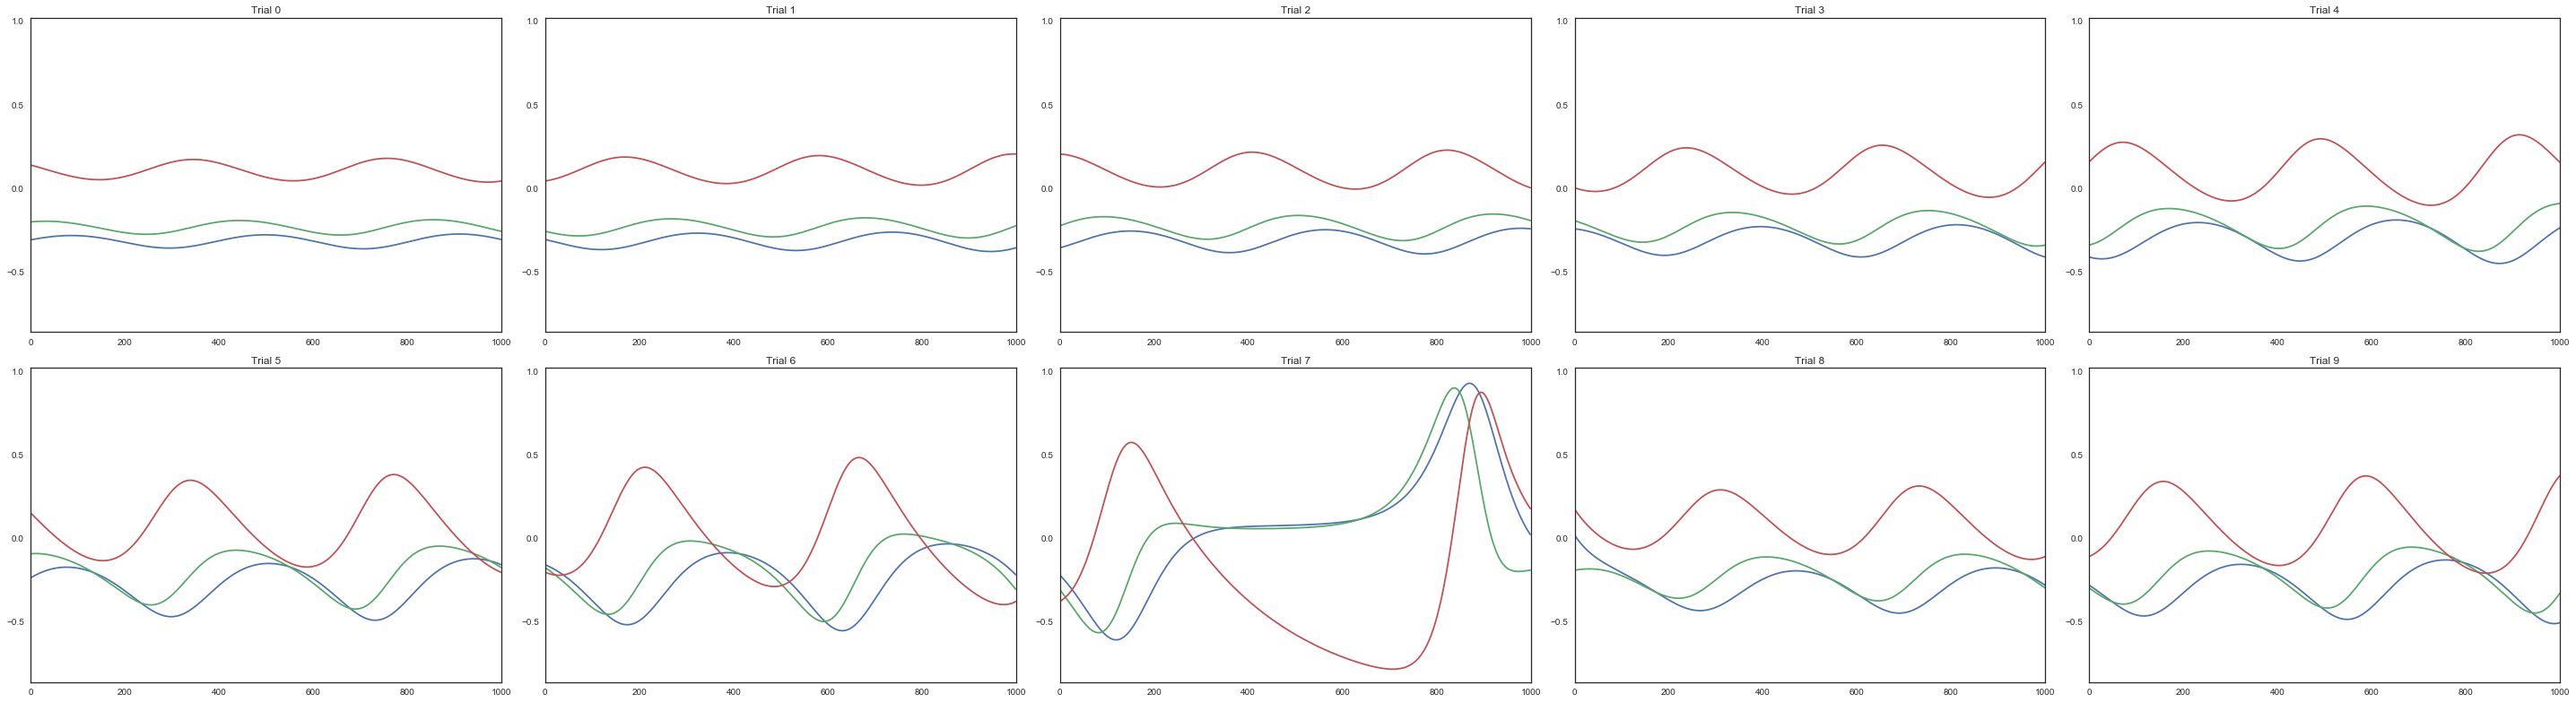

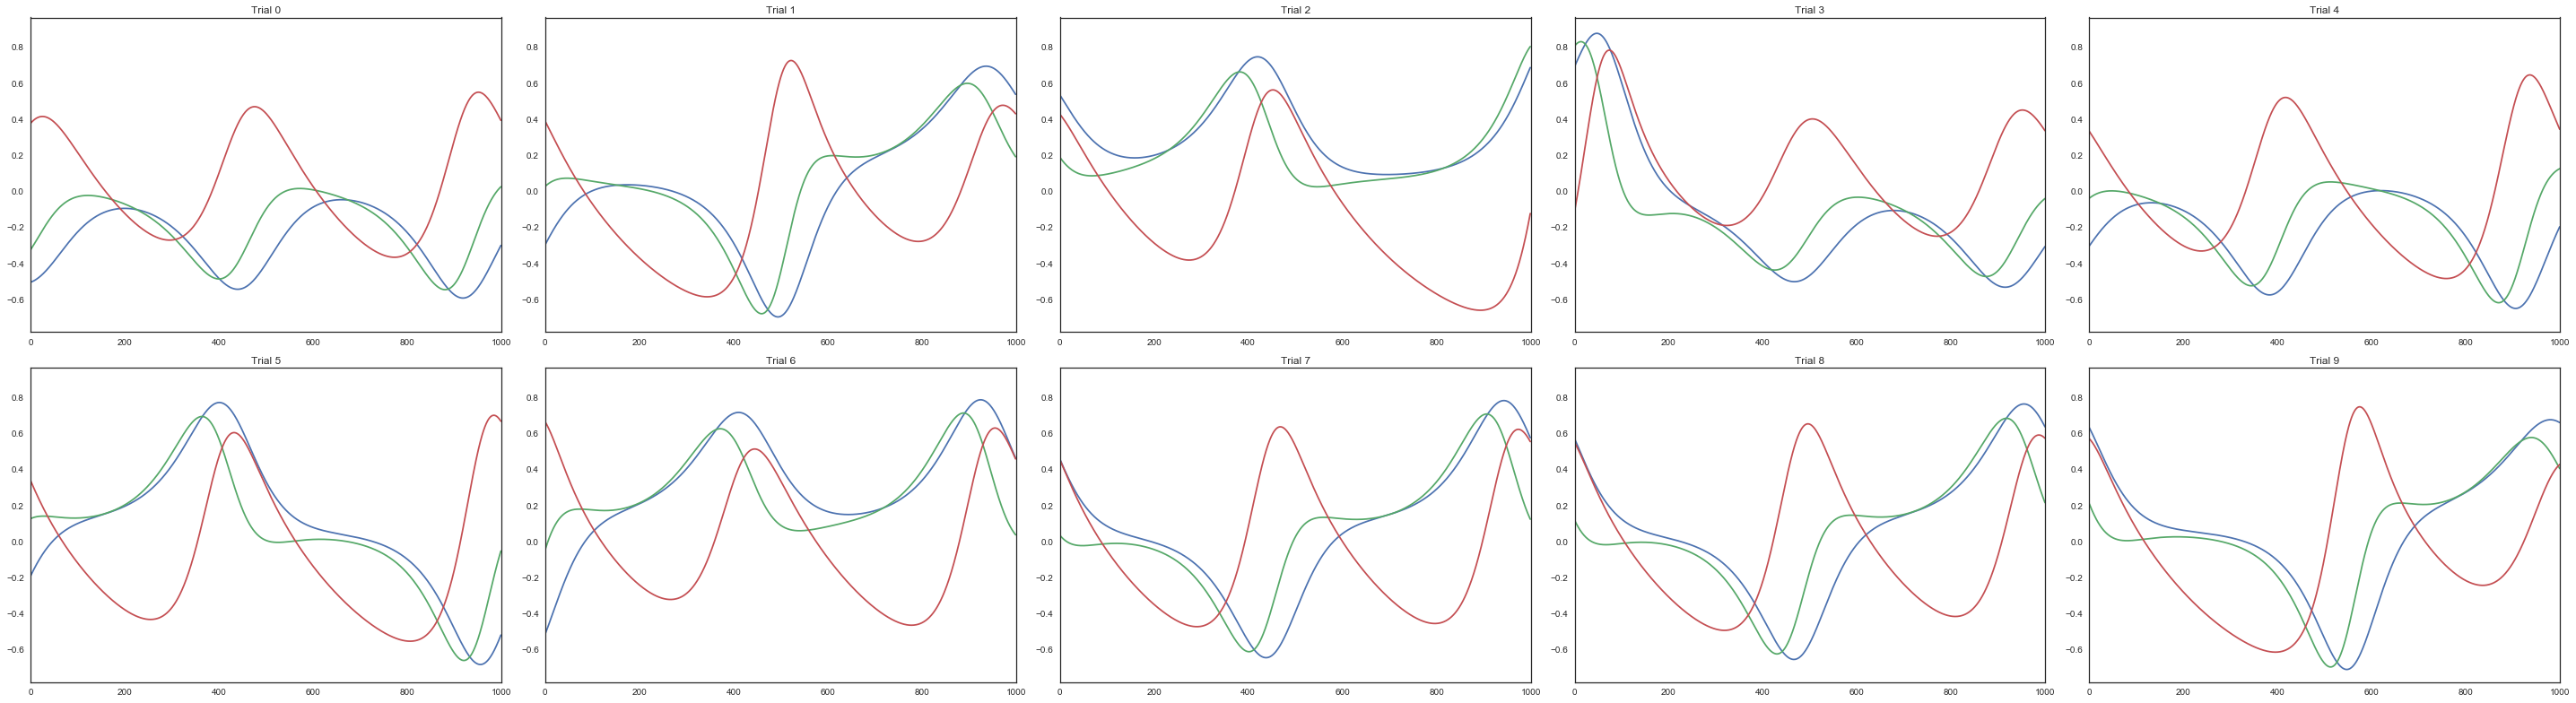

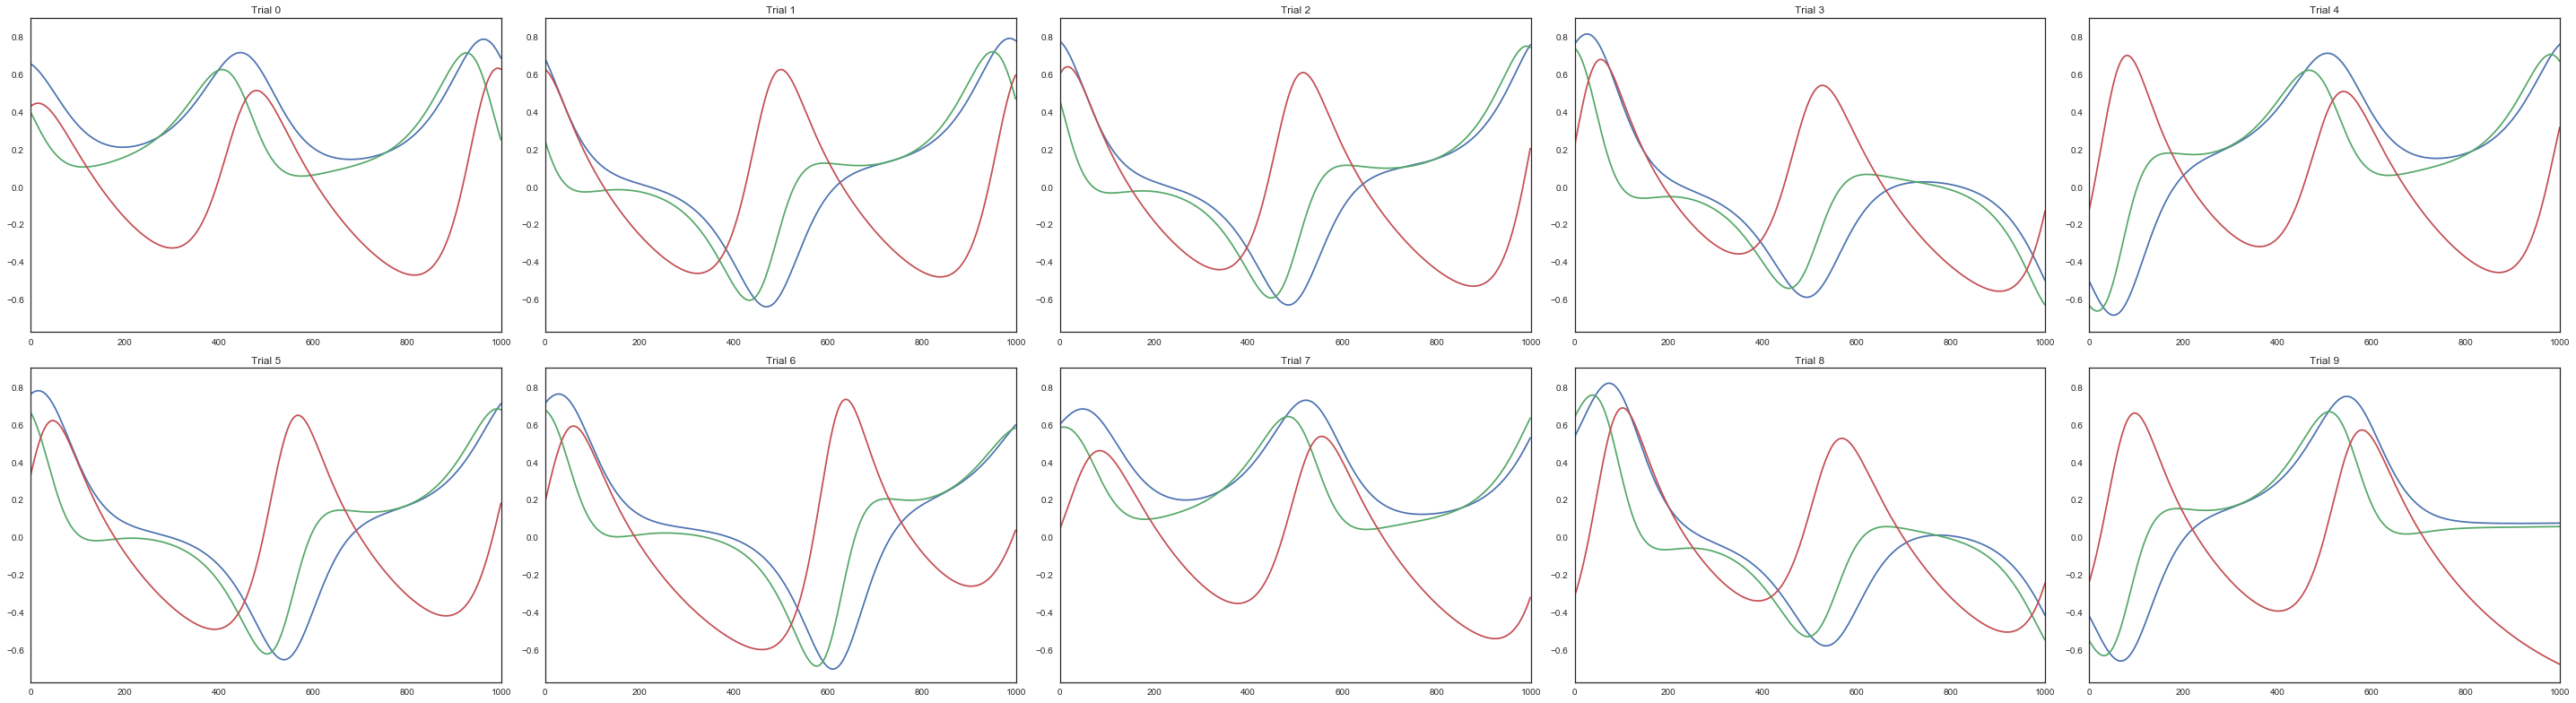

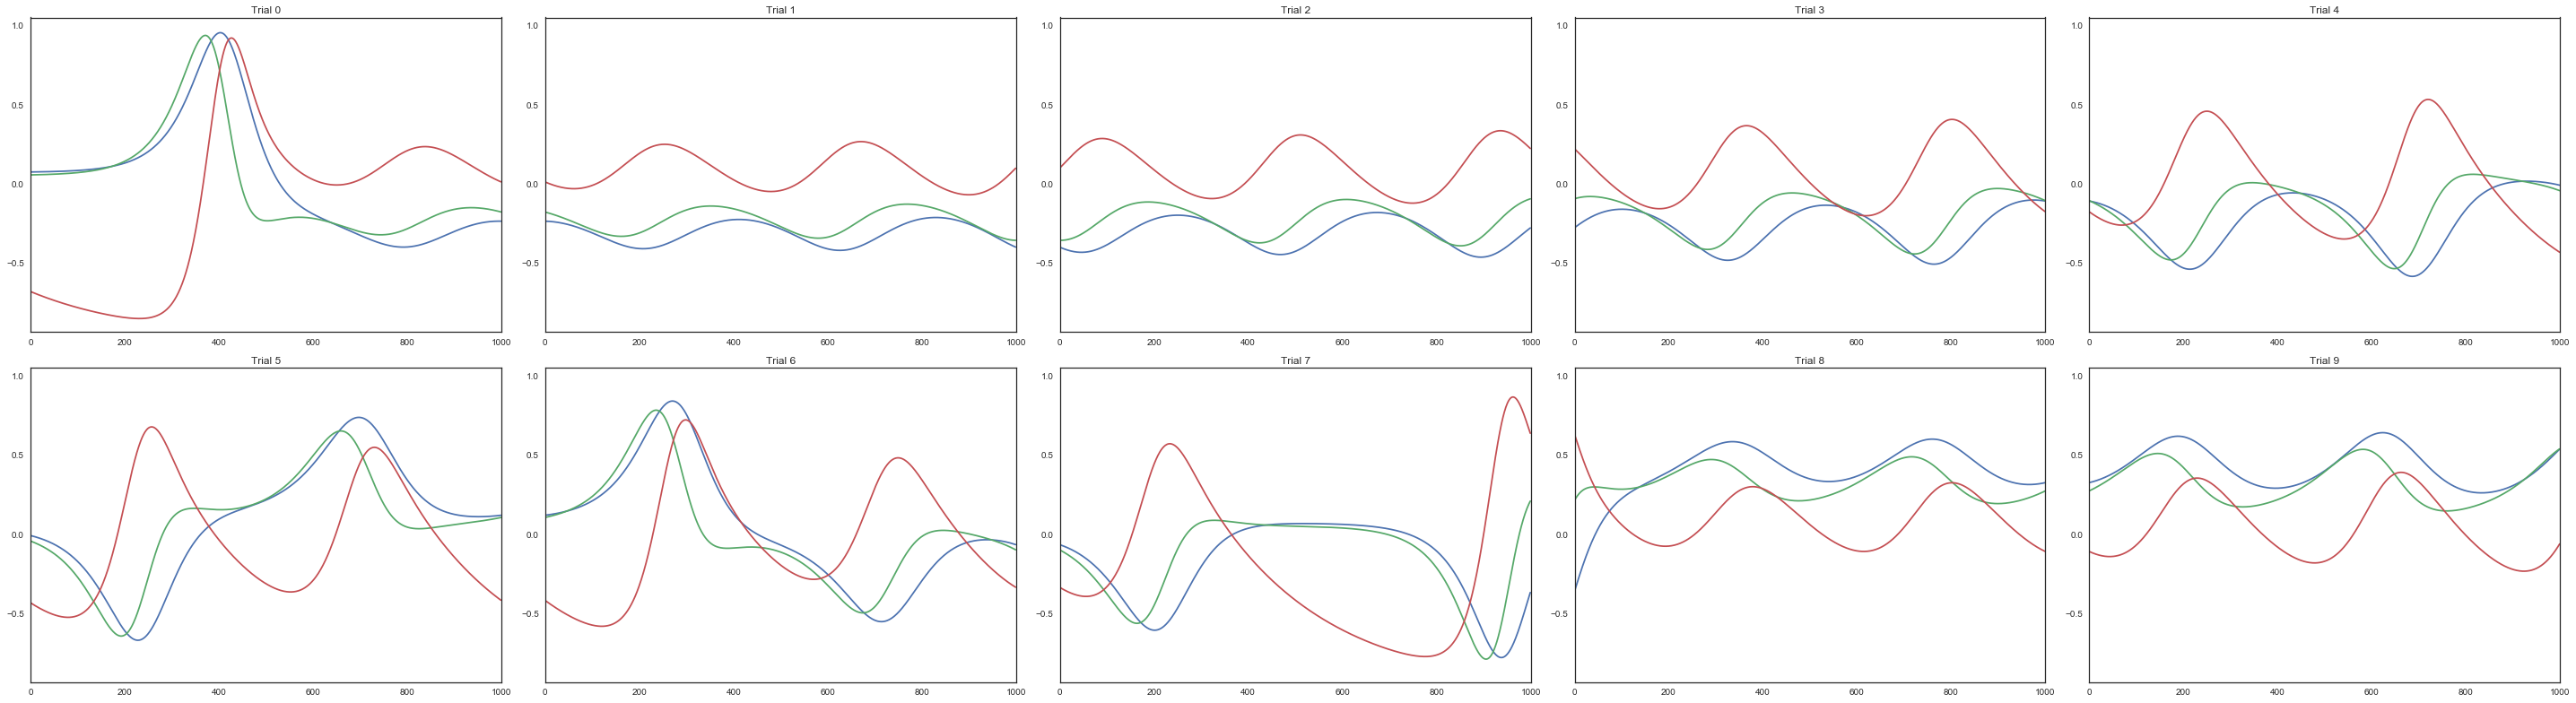

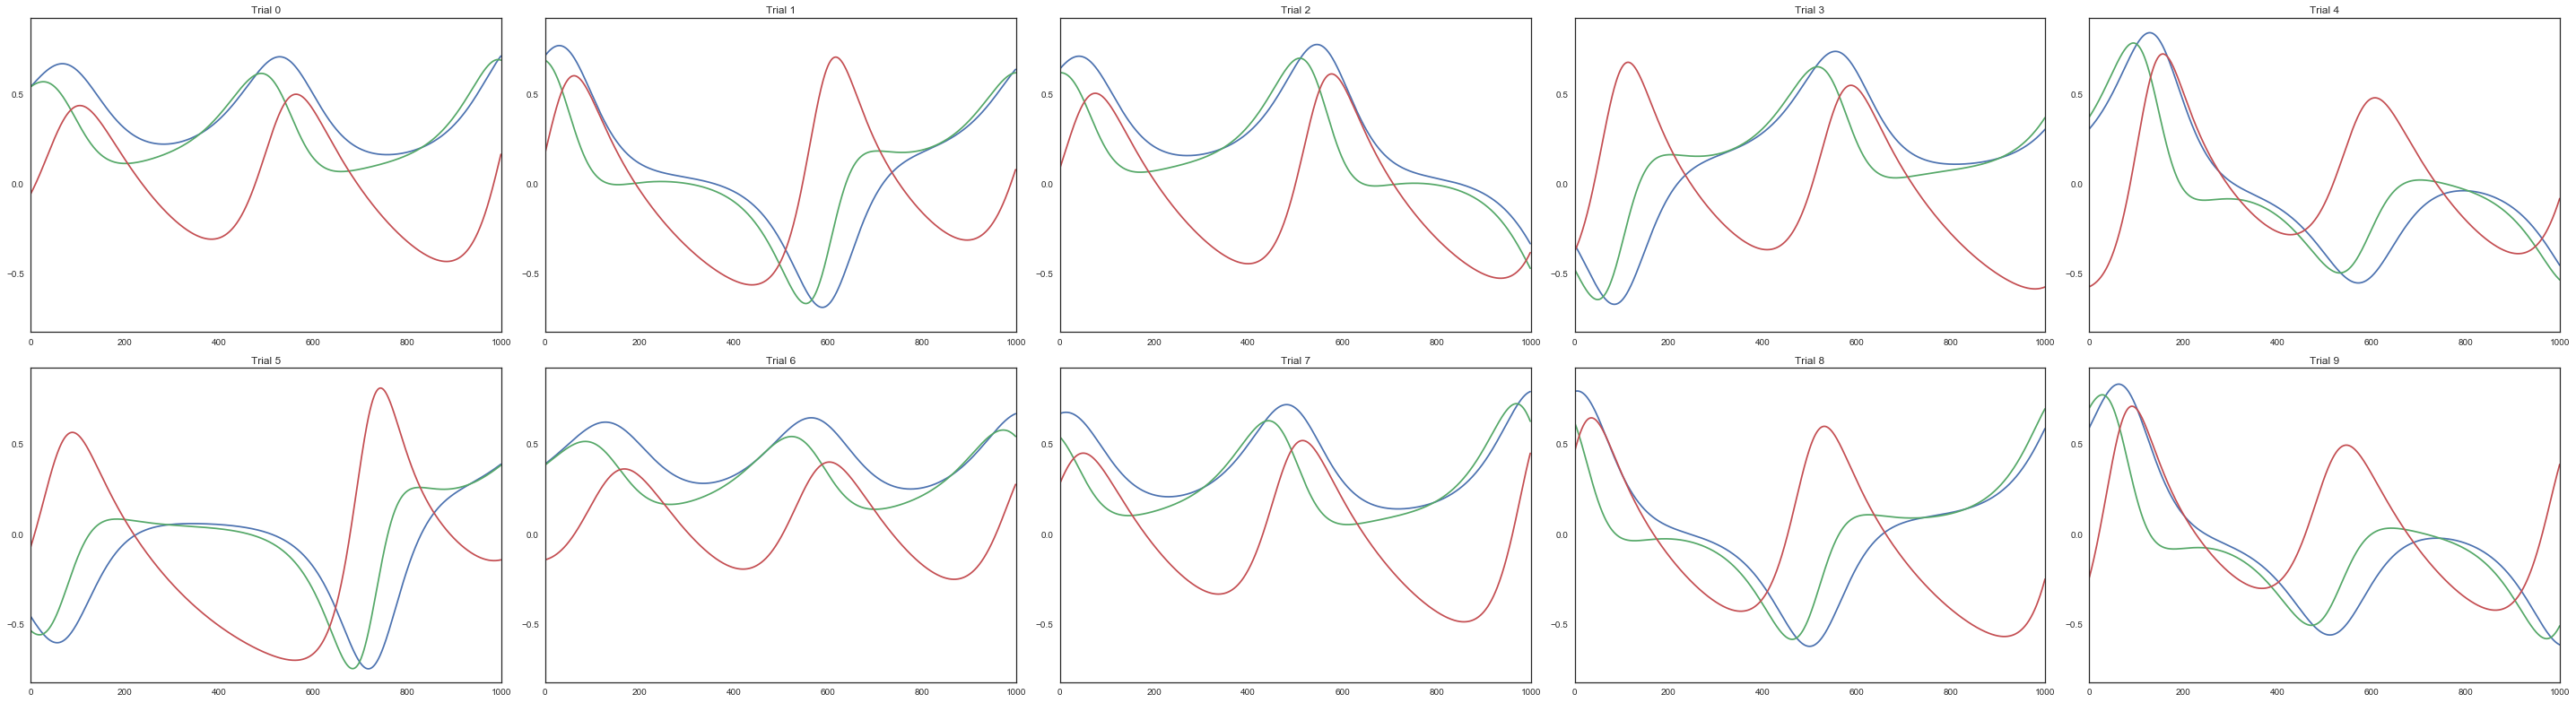

In [8]:
# dimensions
nsample = 5
ntrial = 10
ntime = 1000
nspike = 50
nlatent = 3

np.random.seed(0)
skip = 2000
lorenz = simulation.lorenz(skip + nsample * ntrial * ntime, dt=1.5e-3, x0=np.random.random(3))
lorenz = (lorenz - lorenz.mean(axis=0)) / norm(lorenz, axis=0, ord=np.inf)
x = lorenz[skip:, :].reshape((nsample, ntrial, ntime, -1))
for i in range(5):
    graph.dynplot(x[i, :], ncol=5)

# Simulate spike trains

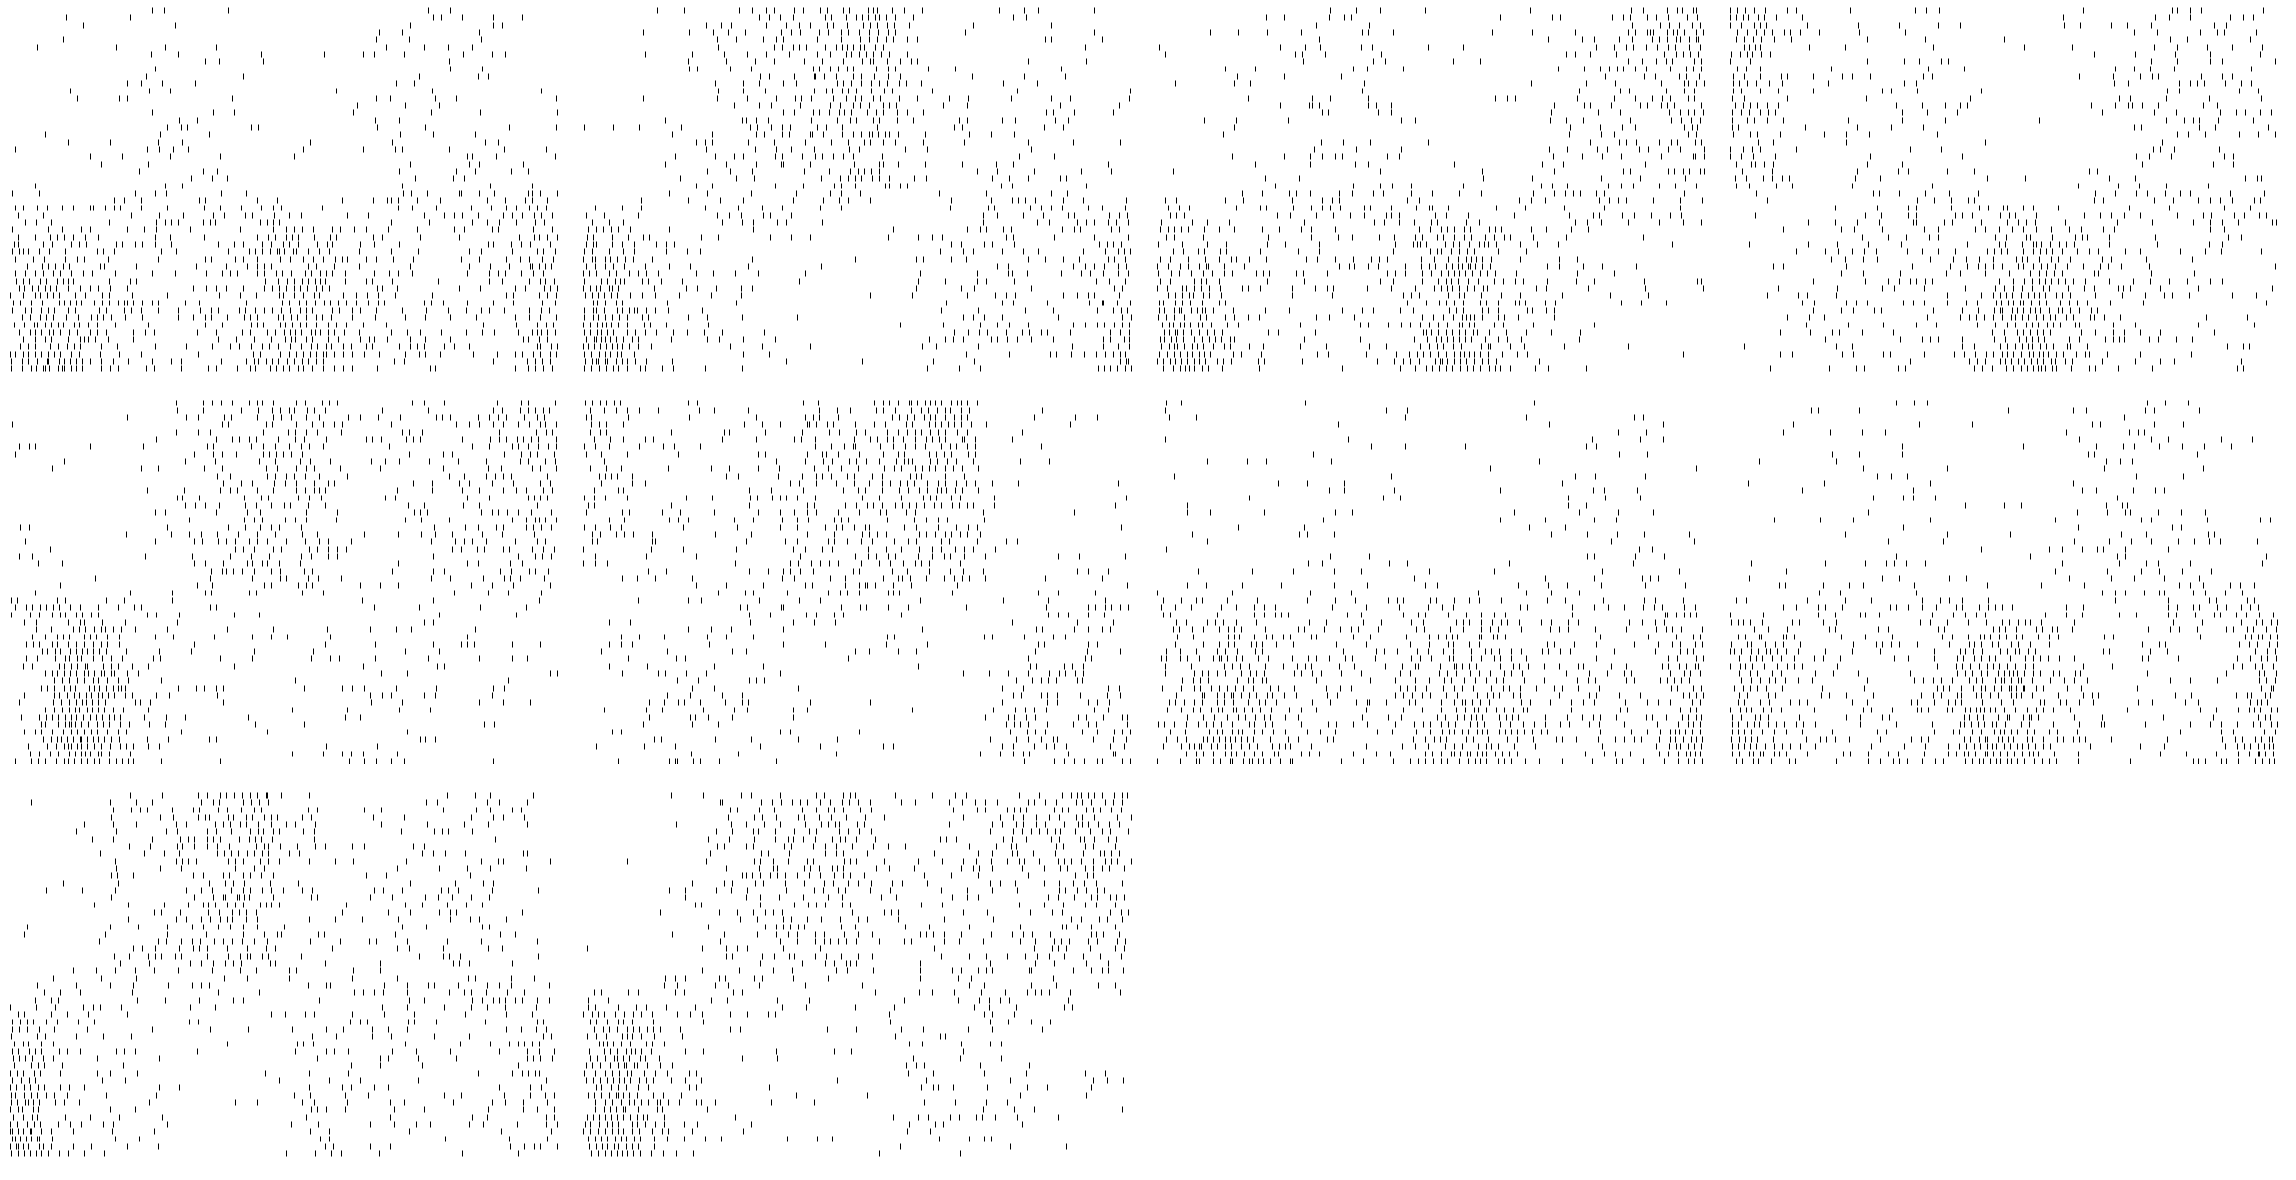

In [282]:
np.random.seed(0)
low = np.log(15 / ntime)
aspk = np.sort((np.random.rand(nlatent, nspike) + 1) * np.sign(np.random.randn(nlatent, nspike)), axis=1)
bspk = np.vstack((low * np.ones(nspike), -10 * np.ones(nspike), -10 * np.ones(nspike), -3 * np.ones(nspike), 
                  -3 * np.ones(nspike), -3 * np.ones(nspike), -3 * np.ones(nspike), -2 * np.ones(nspike),
                  -2 * np.ones(nspike), -1 * np.ones(nspike), -1 * np.ones(nspike)))

y = np.empty((nsample, ntrial, ntime, nspike))  # spike trains
rate = np.empty_like(y)  # firing rates
samples = []
fsample = []

for i in range(nsample):
    y[i, :], _, rate[i, :] = simulation.spike(x[i, :], aspk, bspk)
#     print('mean firing rate per neuron', y.mean(axis=(0, 1)) * 1000)
    samples.append({'y': y[i, :], 'rate': rate[i, :], 'x': x[i, :], 'alpha': aspk, 'beta':bspk})
    fname = '{}/sample{}'.format(path, i + 1)
    fsample.append(fname)
    savemat(fname, samples[i])
graph.rasterplot(y[nsample - 1, :]);

In [42]:
fsample = ['{}/sample{}'.format(path, i + 1) for i in range(nsample)]
sigma = np.full(nlatent, fill_value=1.0)
omega = np.full(nlatent, fill_value=1e-5)

# vLGPAngle = pd.DataFrame(columns=['LatentAngle', 'LoadingAngle', 'Time', 'Model', 'Sample'])
for i, fname in enumerate(fsample):
    print('Sample {}'.format(i + 1))
    sample = loadmat(fname, squeeze_me=True)
    result = inference.multitrials(sample['y'], None, sigma, omega, x=sample['x'], 
                                   ta=sample['alpha'], tb=sample['beta'], lag=10, rank=100, 
                                   niter=100, tol=1e-5, verbose=False)
    savemat(fname + 'vLGP', result)
#     df = pd.DataFrame(np.vstack((rad2deg(result['stat']['latentAngle'][1:]), 
#                       rad2deg(result['stat']['loadingAngle'][1:]), 
#                       np.cumsum(result['stat']['elapsed'][1:, 2]))).T, 
#                       columns=['LatentAngle', 'LoadingAngle', 'Time'])
#     df['Model'] = 'vLGP'
#     df['Sample'] = i + 1
#     vLGPAngle = vLGPAngle.append(df)
print('Done.')

# Collect results
vLGPres = []
for i, fname in enumerate(fsample):
    vLGPres.append(loadmat(fname + 'vLGP', squeeze_me=True))

Sample 1

Inference starting
Inference ending

19 iterations, ELBO: -53145.2706, elapsed: 39.49, converged: True

Sample 2

Inference starting
ELBO decreased. Backtracking.
Adagrad enabled.
Inference ending

20 iterations, ELBO: -55885.9748, elapsed: 42.25, converged: True

Sample 3

Inference starting
ELBO decreased. Backtracking.
Adagrad enabled.
Inference ending

18 iterations, ELBO: -56164.3918, elapsed: 37.79, converged: True

Sample 4

Inference starting
Inference ending

16 iterations, ELBO: -56999.7250, elapsed: 33.88, converged: True

Sample 5

Inference starting
ELBO decreased. Backtracking.
Adagrad enabled.
Inference ending

24 iterations, ELBO: -56833.1454, elapsed: 49.99, converged: True

Done.


Sample 4
Latent subspace angle: 88.62 deg
Loading subspace angle: 73.95 deg
48.6516009791


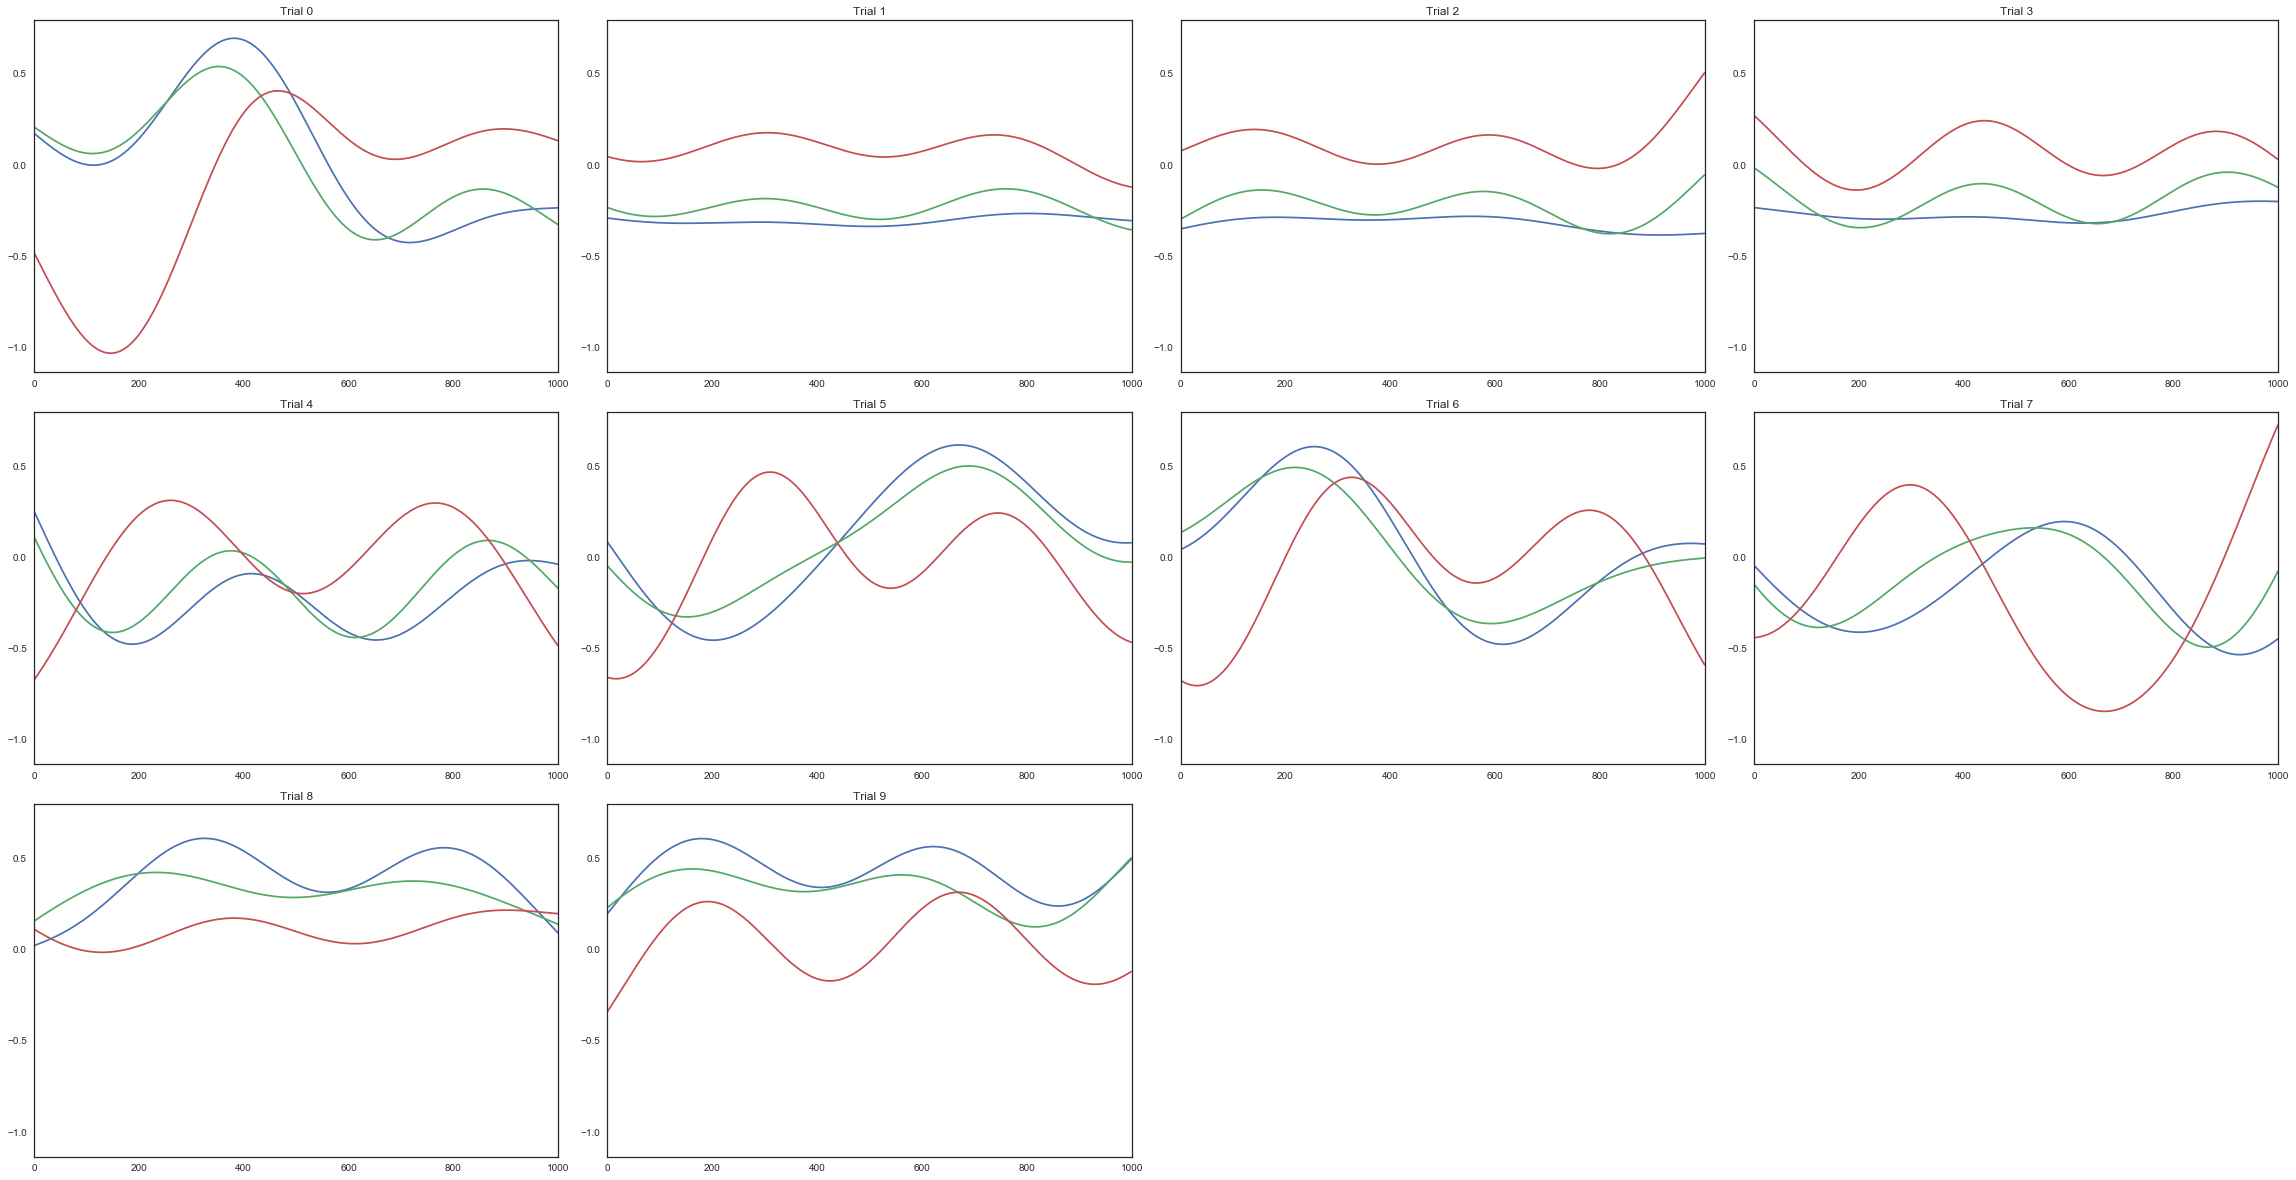

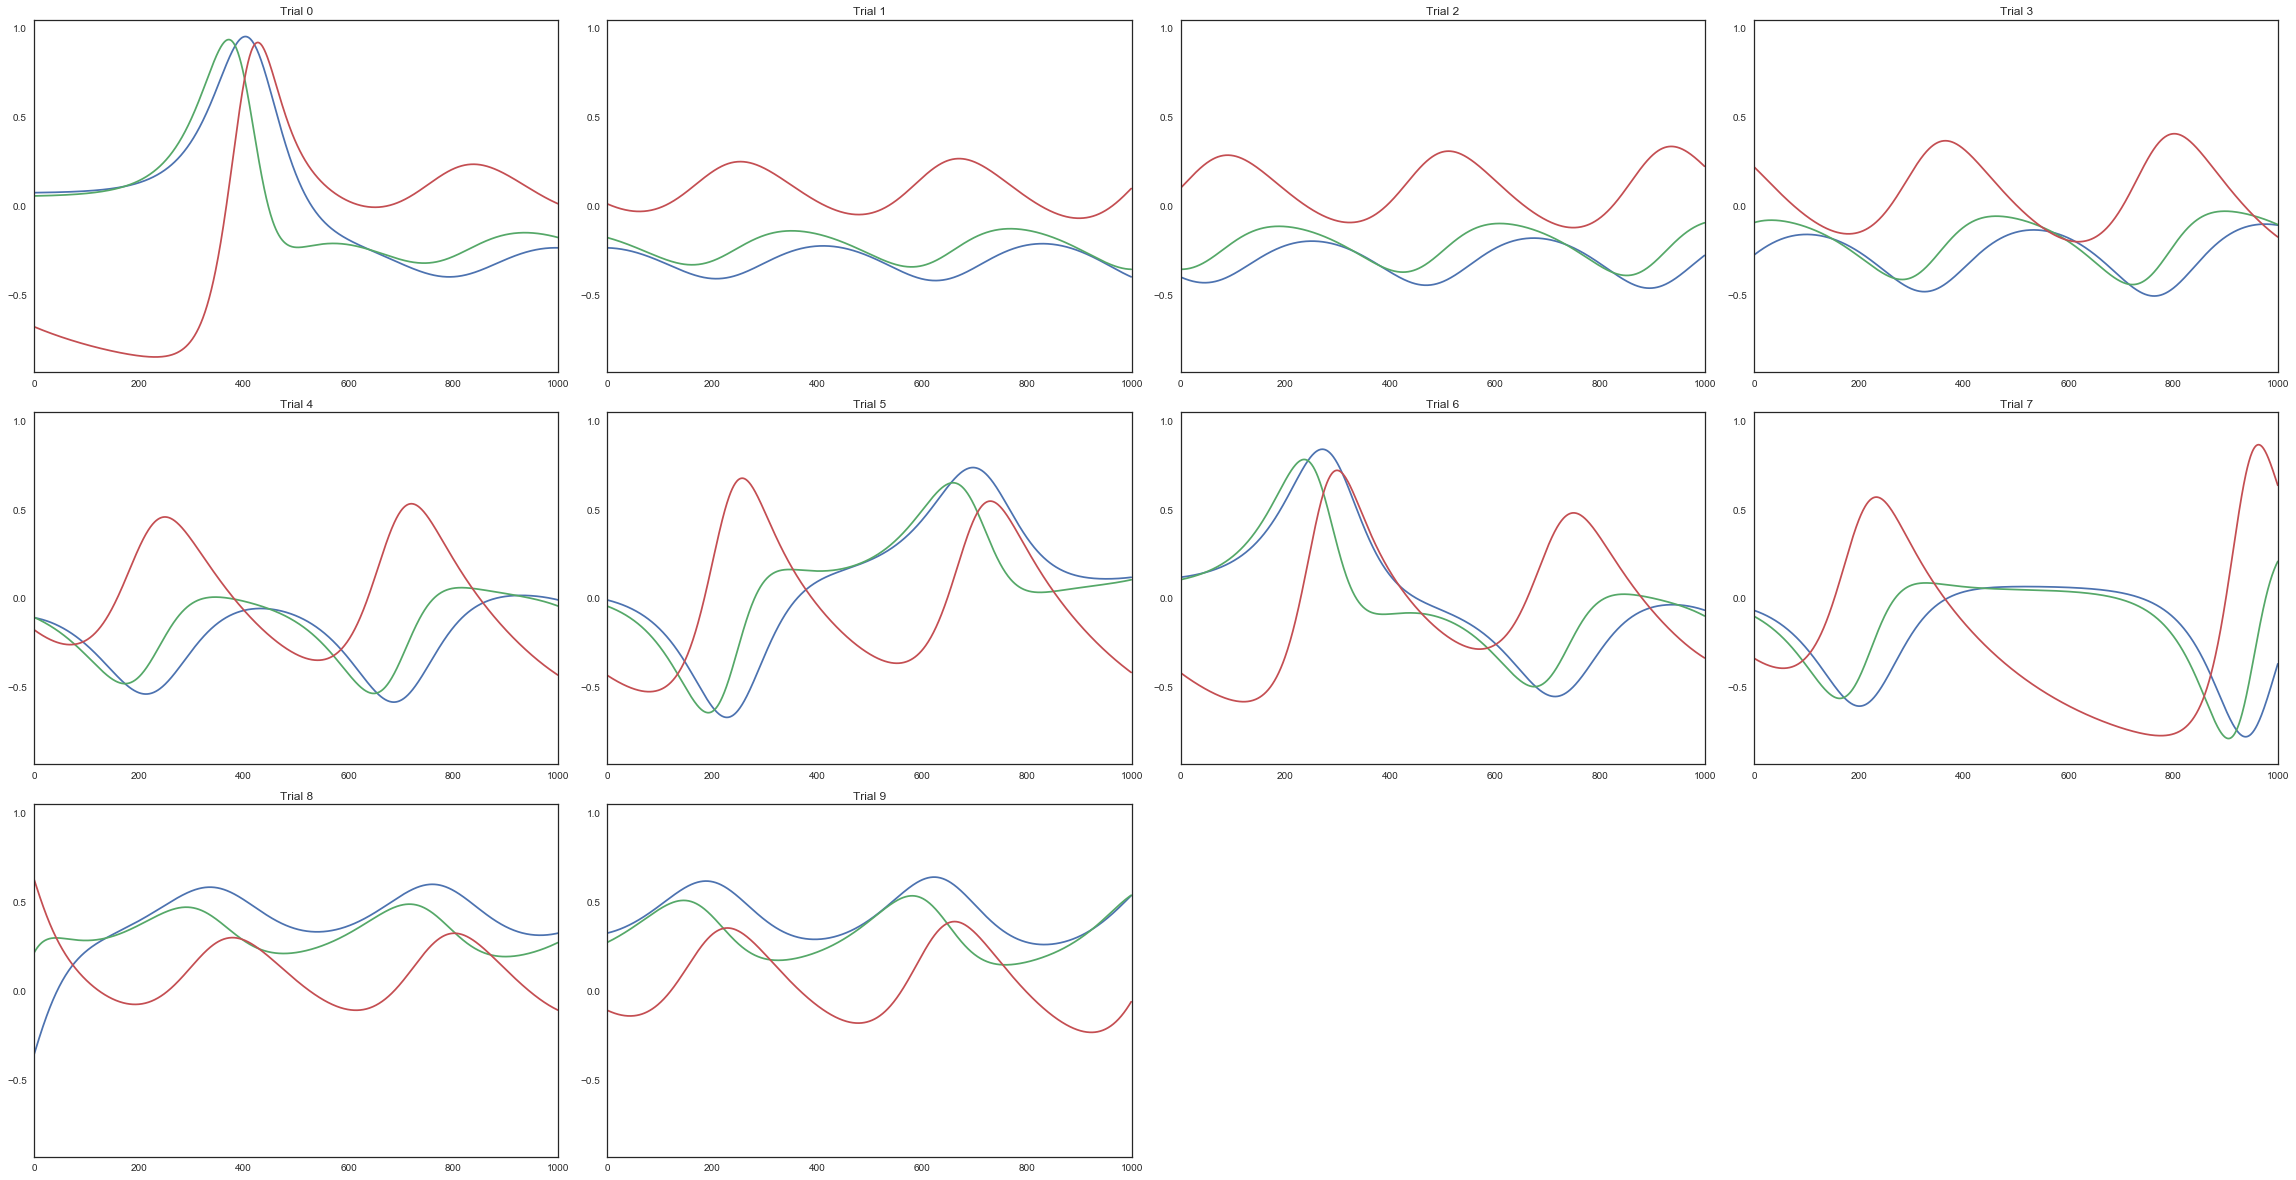

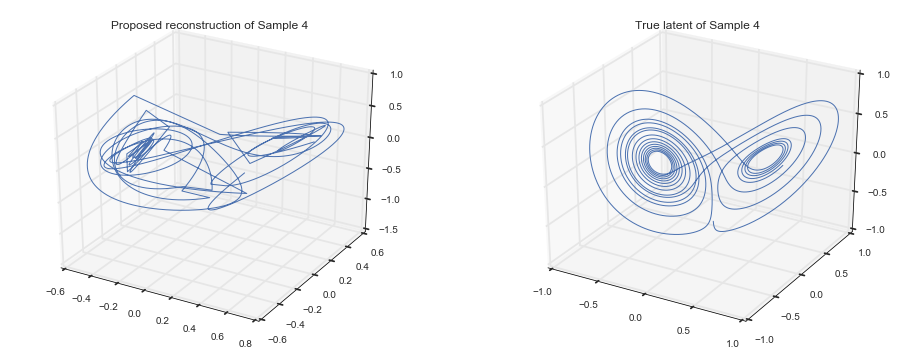

In [55]:
# idx = np.array([r['latentAngle'][-1] for r in vLGPres]).argmin()
idx = 3
print('Sample {}'.format(idx + 1))
bestvLGP = vLGPres[idx]
print('Latent subspace angle: {:.2f} deg'.format(rad2deg(bestvLGP['latentAngle'][-1])))
print('Loading subspace angle: {:.2f} deg'.format(rad2deg(bestvLGP['loadingAngle'][-1])))
# bestvLGPx = util.align(bestvLGP['mu'])
bestvLGPx = bestvLGP['mu']
rotated = np.empty_like(bestvLGPx)
for i in range(ntrial):
    rotated[i, :] = util.rotate(util.add_constant(bestvLGPx[i, :]), bestvLGP['x'][i, :])

# rotated = util.align(rotated)
print(rad2deg(subspace(rotated.reshape((-1, nlatent)), bestvLGP['x'].reshape((-1, nlatent)))))
graph.dynplot(rotated.reshape((ntrial, -1, nlatent)))
graph.dynplot(bestvLGP['x'])

fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(projection='3d'))
recon = rotated.reshape((-1, nlatent))
ax[0].plot(recon[:, 0], recon[:, 1], recon[:, 2], lw=1);
# ax[0].set_xlim3d(-1, 1);
# ax[0].set_ylim3d(-1, 1);
# ax[0].set_zlim3d(-1, 1);
ax[0].set_title('Proposed reconstruction of Sample {}'.format(idx + 1));
ax[1].plot(bestvLGP['x'].reshape((-1, nlatent))[:, 0], bestvLGP['x'].reshape((-1, nlatent))[:, 1], bestvLGP['x'].reshape((-1, nlatent))[:, 2], lw=1);
ax[1].set_xlim3d(-1, 1);
ax[1].set_ylim3d(-1, 1);
ax[1].set_zlim3d(-1, 1);
ax[1].set_title('True latent of Sample {}'.format(idx + 1));

LatentAngle     67.7577
LoadingAngle    66.7033
Time            31.0154
Model              vLGP
Name: 3.0, dtype: object


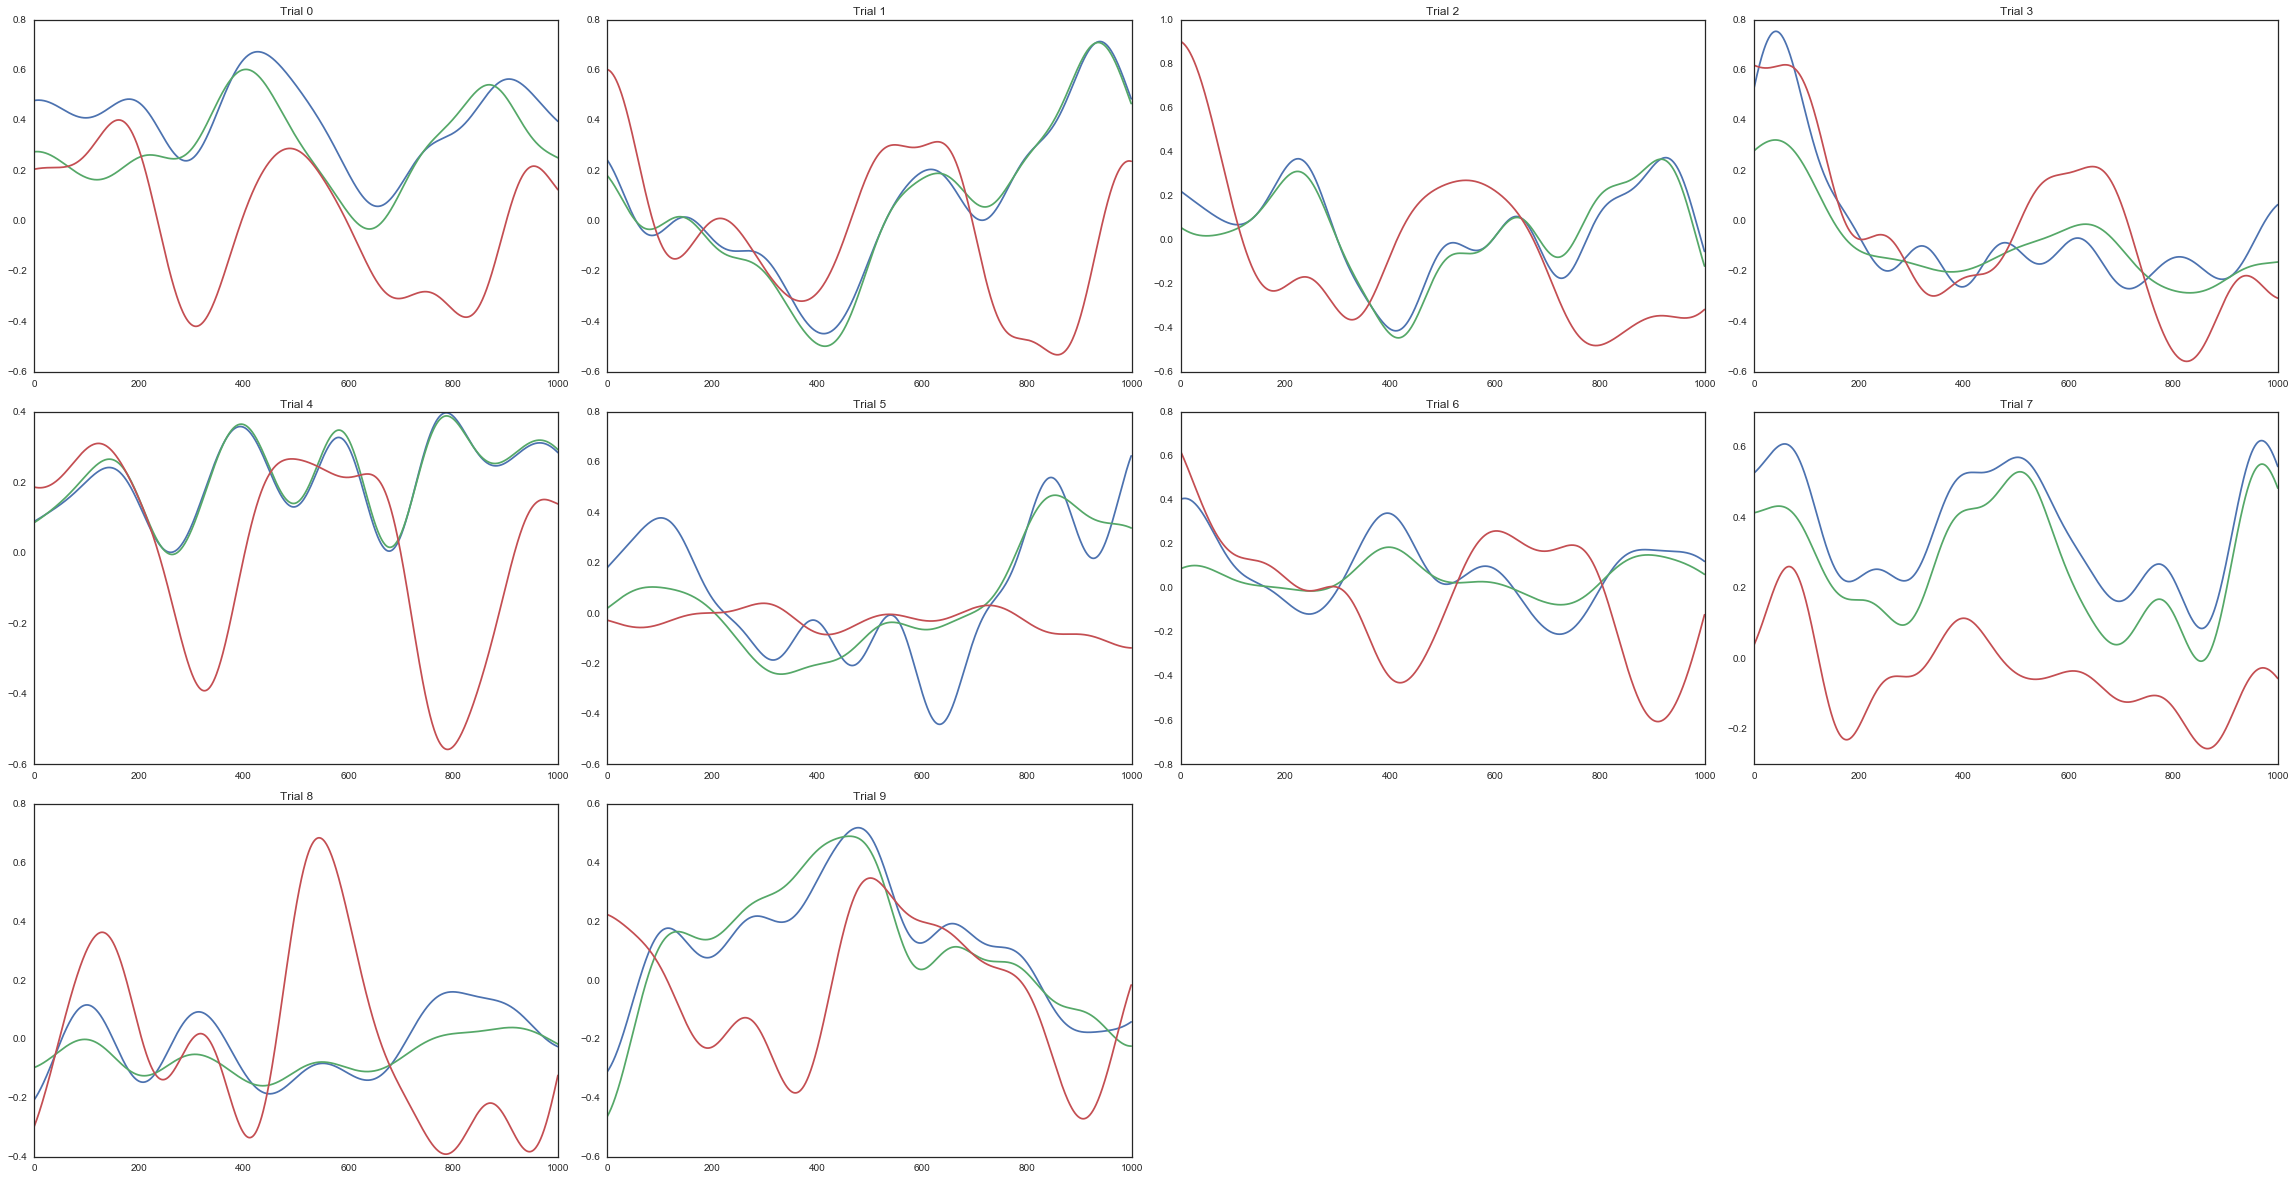

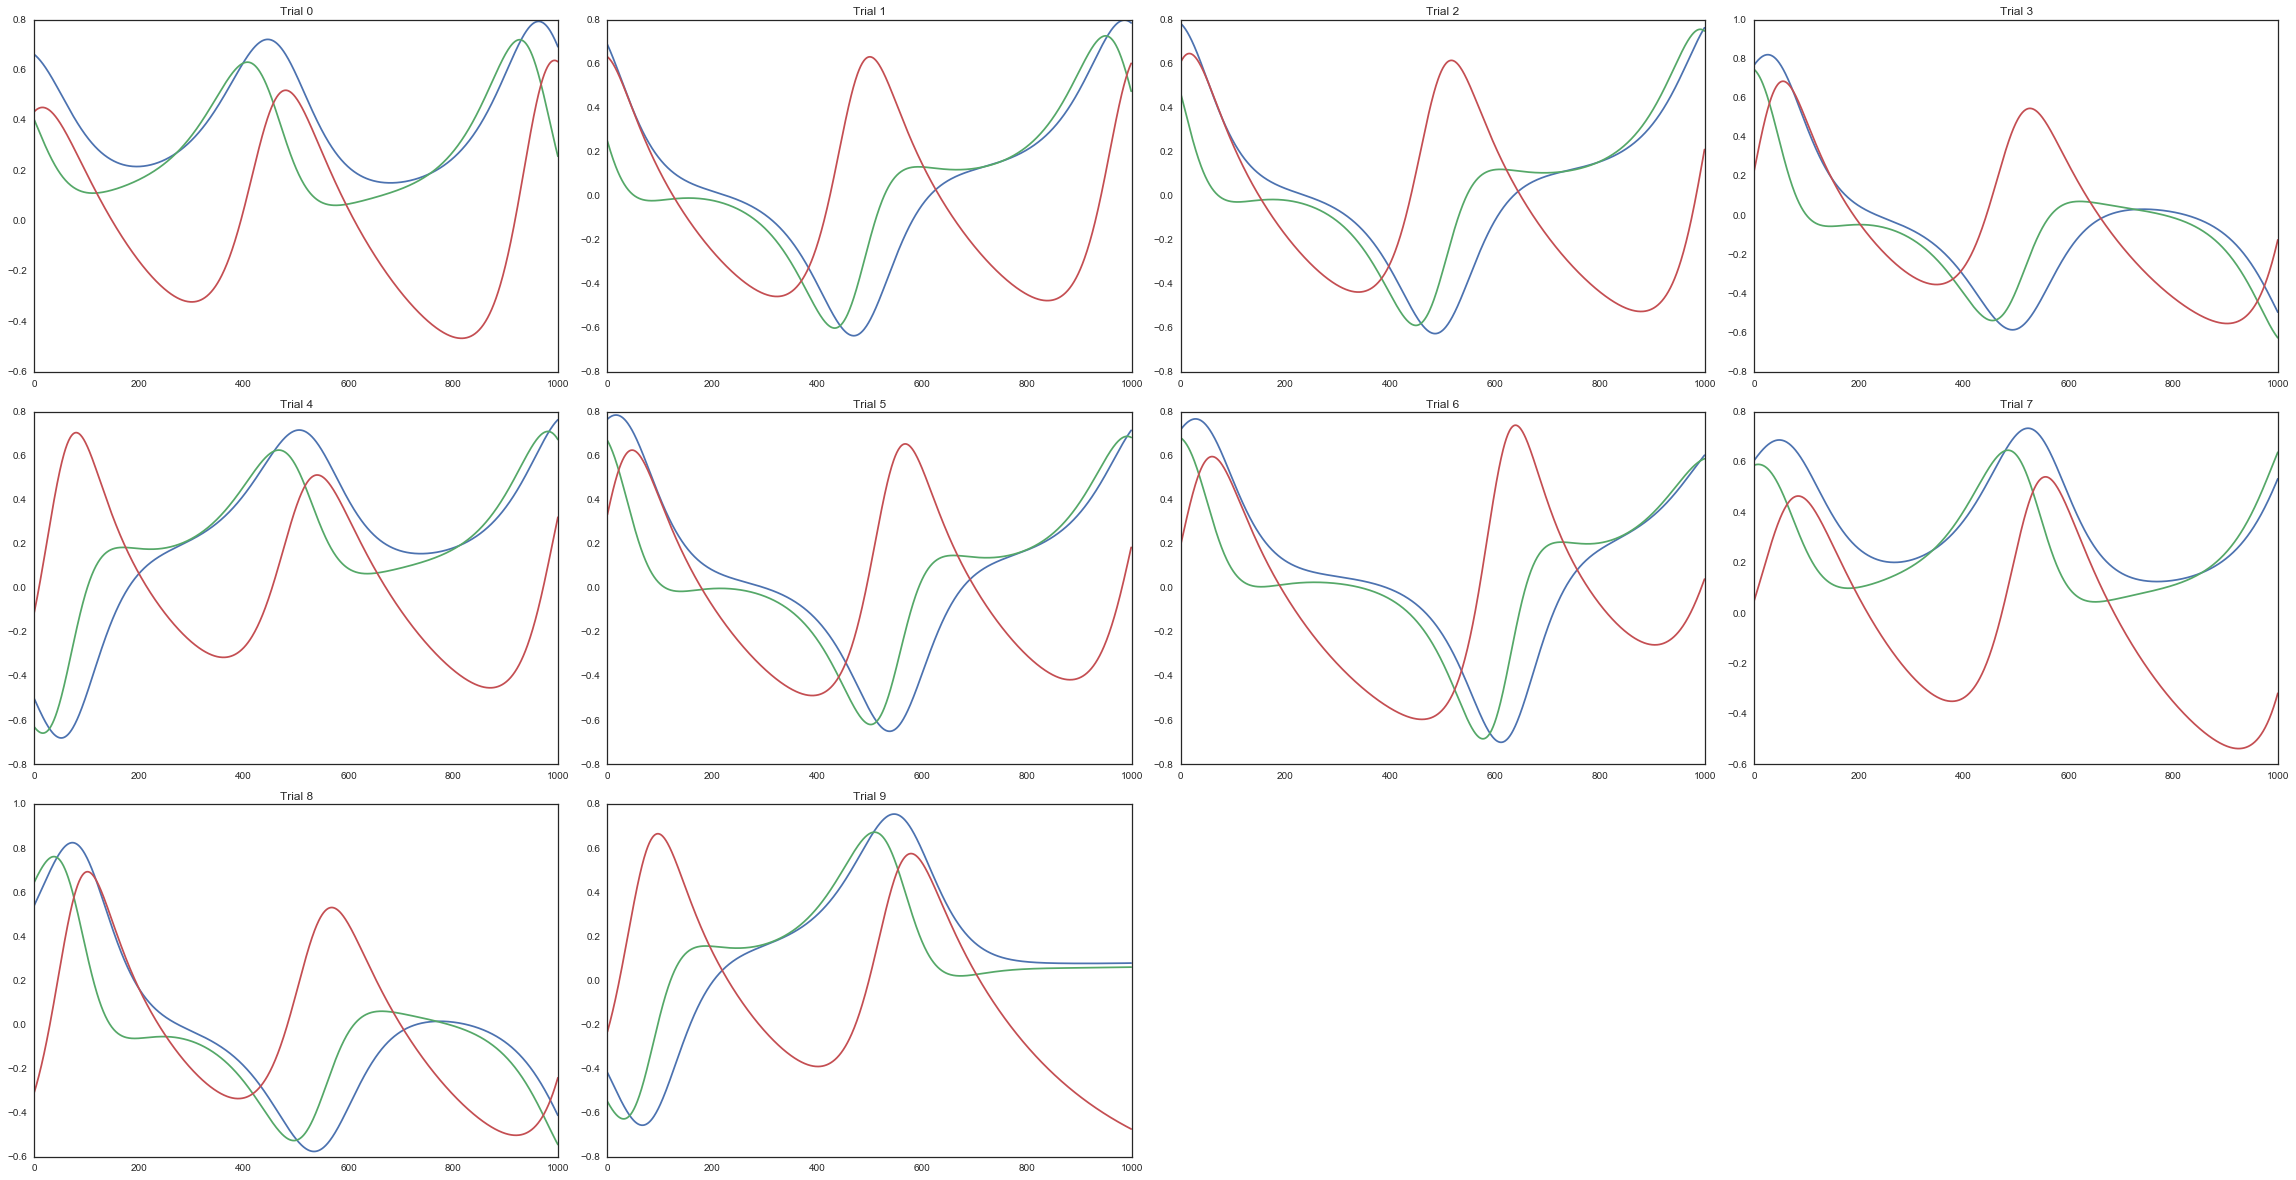

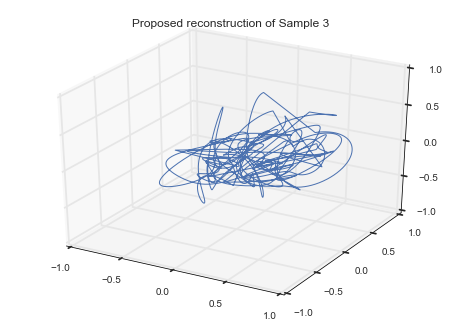

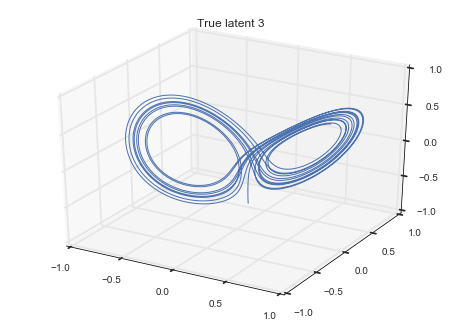

In [285]:
vLGPlast = vLGPAngle.groupby('Sample').last()
bestvLGP = vLGPlast.ix[vLGPlast['LatentAngle'].idxmin()]
ibestvLGP = int(bestvLGP.name) - 1

print(bestvLGP)

bestvLGPx = loadmat(path + '/sample{}vLGP'.format(ibestvLGP))['posterior']['mu'][0,0]

# rotated = util.rotate(util.add_constant(bestvLGPx.reshape((-1, nlatent))), x[ibestvLGP, :].reshape((-1, nlatent)))
rotated = np.empty_like(x[ibestvLGP, :])
for i in range(ntrial):
    rotated[i, :] = util.rotate(util.add_constant(bestvLGPx[i, :]), x[ibestvLGP, i, :])

graph.dynplot(rotated.reshape((ntrial, -1, nlatent)))
graph.dynplot(x[ibestvLGP, :])

fig = plt.figure()
ax = fig.gca(projection='3d')
recon = rotated.reshape((-1, nlatent))
ax.plot(recon[:, 0], recon[:, 1], recon[:, 2], lw=1);
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
plt.title('Proposed reconstruction of Sample {}'.format(ibestvLGP + 1));
plt.savefig('figure/proposed.pdf');

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x[ibestvLGP,:].reshape((-1, nlatent))[:, 0], x[ibestvLGP,:].reshape((-1, nlatent))[:, 1], x[ibestvLGP,:].reshape((-1, nlatent))[:, 2], lw=1);
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
plt.title('True latent {}'.format(ibestvLGP + 1));

In [152]:
# Run GPFA before loading GPFA results
GPFAresult = ['data/sample_lorenz{}GPFA'.format(s) for s in range(nsample)]
GPFAAngle = pd.DataFrame(columns=['LatentAngle', 'LoadingAngle', 'Time', 'Model', 'Sample'])
for i, fname in enumerate(GPFAresult):
    GPFA = loadmat(fname)
    df = pd.DataFrame(np.hstack((GPFA['latentAngles'] * 180 / np.pi, 
                      GPFA['loadingAngles'] * 180 / np.pi, 
                      np.cumsum(GPFA['iterTime'])[...,None])), columns=['LatentAngle', 'LoadingAngle', 'Time'])
    df['Model'] = 'GPFA'
    df['Sample'] = i
    GPFAAngle = GPFAAngle.append(df)

LatentAngle     44.8306
LoadingAngle    56.6531
Time            15.9892
Model              GPFA
Name: 3.0, dtype: object


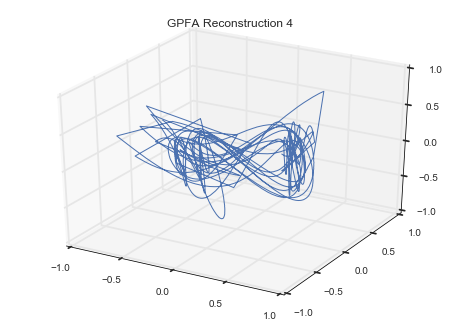

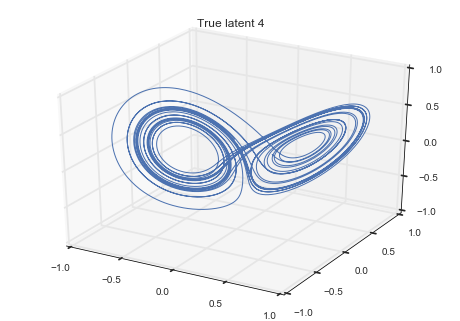

In [225]:
GPFAlast = GPFAAngle.groupby('Sample').last()
bestGPFA = GPFAlast.ix[GPFAlast['LatentAngle'].idxmin()]
print(bestGPFA)

ibestGPFA = int(bestGPFA.name)
bestGPFAresult = loadmat('data/sample_lorenz{}GPFA'.format(ibestGPFA))
bestGPFAx = np.rollaxis(np.dstack(np.squeeze(bestGPFAresult['seqTrain']['xsm'])), axis=-1).transpose((0, 2,1))

rotated = util.rotate(util.add_constant(bestGPFAx.reshape((-1, nlatent))), x[ibestGPFA,:].reshape((-1, nlatent)))
fig = plt.figure()
ax = fig.gca(projection='3d')
recon = rotated
ax.plot(recon[:, 0], recon[:, 1], recon[:, 2], lw=1);
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
plt.title('GPFA Reconstruction {}'.format(ibestGPFA + 1));
plt.savefig('figure/GPFARecon.pdf');

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x[ibestGPFA,:].reshape((-1, nlatent))[:, 0], x[ibestGPFA,:].reshape((-1, nlatent))[:, 1], x[ibestGPFA,:].reshape((-1, nlatent))[:, 2], lw=1);
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
plt.title('True latent {}'.format(ibestGPFA + 1));

In [164]:
# Run PLDS before loading PLDS results
PLDSresult = ['data/sample_lorenz{}PLDS'.format(s) for s in range(nsample)]
PLDSAngle = pd.DataFrame(columns=['LatentAngle', 'LoadingAngle', 'Time', 'Model', 'Sample'])
for i, fname in enumerate(PLDSresult):
    PLDS = loadmat(fname)
    df = pd.DataFrame(np.hstack((PLDS['latentAngles'] * 180 / np.pi, 
                      PLDS['loadingAngles'] * 180 / np.pi, 
                      np.cumsum(PLDS['StepTimes'])[...,None])), columns=['LatentAngle', 'LoadingAngle', 'Time'])
    df['Model'] = 'PLDS'
    df['Sample'] = i
    PLDSAngle = PLDSAngle.append(df)

LatentAngle     40.2629
LoadingAngle    18.2209
Time             599.88
Model              PLDS
Name: 3.0, dtype: object


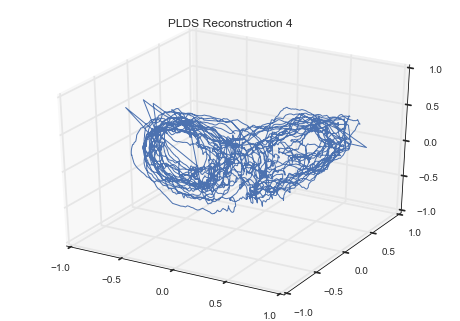

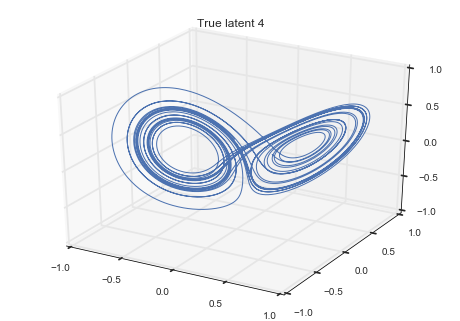

In [226]:
PLDSlast = PLDSAngle.groupby('Sample').last()
bestPLDS = PLDSlast.ix[PLDSlast['LatentAngle'].idxmin()]
print(bestPLDS)

ibestPLDS = int(bestPLDS.name)
bestPLDSresult = loadmat('data/sample_lorenz{}PLDS'.format(ibestPLDS))
bestPLDSx = np.squeeze(bestPLDSresult['xsm']).T.reshape(ntrial, -1, nlatent)

rotated = util.rotate(util.add_constant(bestPLDSx.reshape((-1, nlatent))), x[ibestPLDS, :].reshape((-1, nlatent)))
fig = plt.figure()
ax = fig.gca(projection='3d')
recon = rotated
ax.plot(recon[:, 0], recon[:, 1], recon[:, 2], lw=1);
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
plt.title('PLDS Reconstruction {}'.format(ibestPLDS + 1));
plt.savefig('figure/PLDS.pdf')

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x[ibestPLDS,:].reshape((-1, nlatent))[:, 0], x[ibestPLDS,:].reshape((-1, nlatent))[:, 1], x[ibestPLDS,:].reshape((-1, nlatent))[:, 2], lw=1);
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
plt.title('True latent {}'.format(ibestPLDS + 1));

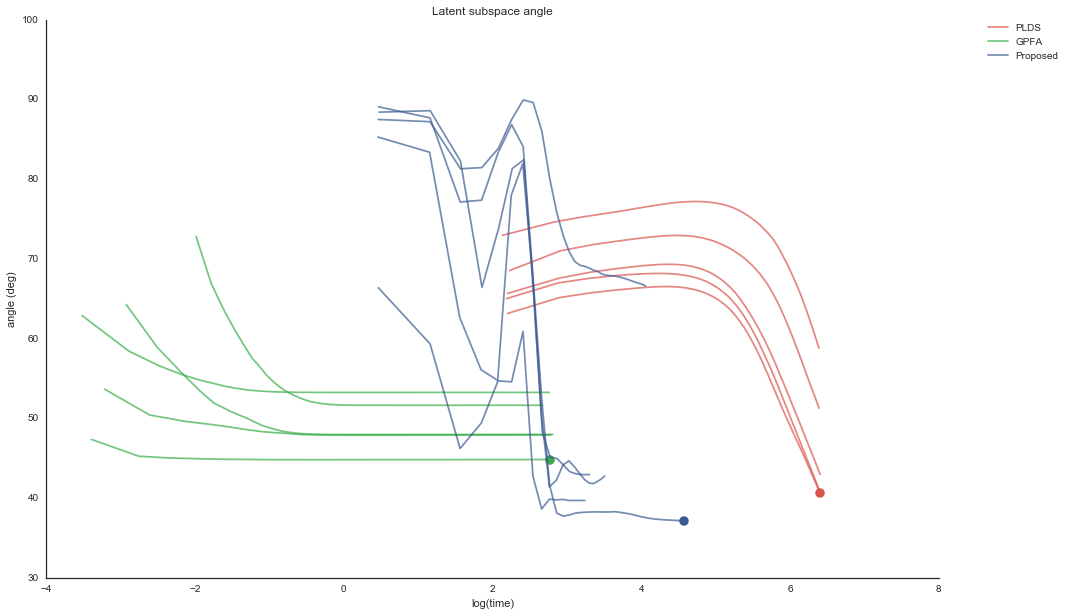

In [178]:
# Latent subspace angle plot
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)
for key, grp in PLDSAngle.groupby('Sample'):
    ax.plot(np.log(grp['Time']), grp['LatentAngle'], color=PLDScolor, alpha=0.7);
for key, grp in GPFAAngle.groupby('Sample'):
    ax.plot(np.log(grp['Time']), grp['LatentAngle'], color=GPFAcolor, alpha=0.7);
for key, grp in vLGPAngle.groupby('Sample'):
    ax.plot(np.log(grp['Time']), grp['LatentAngle'], color=GPVBcolor, alpha=0.7);

PLDSgrp = PLDSAngle.groupby('Sample')
angle = PLDSgrp.get_group(ibestPLDS).dropna().tail(1)['LatentAngle']
time = PLDSgrp.get_group(ibestPLDS).dropna().tail(1)['Time']
ax.scatter(np.log(time), angle, color=PLDScolor, lw=5)
    
GPFAgrp = GPFAAngle.groupby('Sample')
angle = GPFAgrp.get_group(ibestGPFA).dropna().tail(1)['LatentAngle']
time = GPFAgrp.get_group(ibestGPFA).dropna().tail(1)['Time']
ax.scatter(np.log(time), angle, color=GPFAcolor, lw=5)

vLGPgrp = vLGPAngle.groupby('Sample')
angle = vLGPgrp.get_group(ibestvLGP).dropna().tail(1)['LatentAngle']
time = vLGPgrp.get_group(ibestvLGP).dropna().tail(1)['Time']
ax.scatter(np.log(time), angle, color=GPVBcolor, lw=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlim([-4, 8])
plt.xlabel('log(time)');
plt.ylabel('angle (deg)');
PLDSline = mlines.Line2D([], [], color=PLDScolor, alpha=0.7, label='PLDS');
GPFAline = mlines.Line2D([], [], color=GPFAcolor, alpha=0.7, label='GPFA');
vLGPline = mlines.Line2D([], [], color=GPVBcolor, alpha=0.7, label='Proposed');
plt.legend(handles=[PLDSline, GPFAline, vLGPline], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.title('Latent subspace angle');
plt.savefig('figure/LatentAngle.pdf')

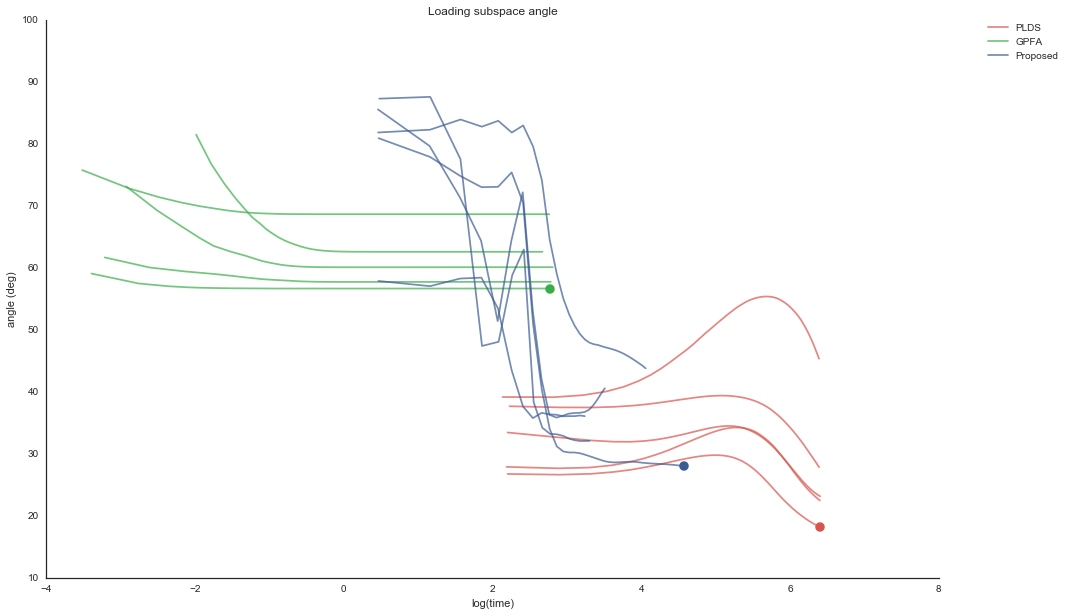

In [179]:
# Loading matrix subspace angle plot
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)
for key, grp in PLDSAngle.groupby('Sample'):
    ax.plot(np.log(grp['Time']), grp['LoadingAngle'], color=PLDScolor, alpha=0.7);
for key, grp in GPFAAngle.groupby('Sample'):
    ax.plot(np.log(grp['Time']), grp['LoadingAngle'], color=GPFAcolor, alpha=0.7);
for key, grp in vLGPAngle.groupby('Sample'):
    ax.plot(np.log(grp['Time']), grp['LoadingAngle'], color=GPVBcolor, alpha=0.7);

PLDSgrp = PLDSAngle.groupby('Sample')
angle = PLDSgrp.get_group(ibestPLDS).dropna().tail(1)['LoadingAngle']
time = PLDSgrp.get_group(ibestPLDS).dropna().tail(1)['Time']
ax.scatter(np.log(time), angle, color=PLDScolor, lw=5)
    
GPFAgrp = GPFAAngle.groupby('Sample')
angle = GPFAgrp.get_group(ibestGPFA).dropna().tail(1)['LoadingAngle']
time = GPFAgrp.get_group(ibestGPFA).dropna().tail(1)['Time']
ax.scatter(np.log(time), angle, color=GPFAcolor, lw=5)

vLGPgrp = vLGPAngle.groupby('Sample')
angle = vLGPgrp.get_group(ibestvLGP).dropna().tail(1)['LoadingAngle']
time = vLGPgrp.get_group(ibestvLGP).dropna().tail(1)['Time']
ax.scatter(np.log(time), angle, color=GPVBcolor, lw=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlim([-4, 8])
plt.xlabel('log(time)');
plt.ylabel('angle (deg)');
PLDSline = mlines.Line2D([], [], color=PLDScolor, alpha=0.7, label='PLDS');
GPFAline = mlines.Line2D([], [], color=GPFAcolor, alpha=0.7, label='GPFA');
vLGPline = mlines.Line2D([], [], color=GPVBcolor, alpha=0.7, label='Proposed');
plt.legend(handles=[PLDSline, GPFAline, vLGPline], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.title('Loading subspace angle');
plt.savefig('figure/LoadingAngle.pdf')

In [180]:
sample = loadmat('data/sample_lorenz3')
yhat = np.empty_like(sample['y'])
for i in range(sample['y'].shape[0]):
    model = inference.gpvb(sample['y'], None, sigma, omega, rank=100, x=sample['x'], lag=3, truea=sample['a'], trueb=sample['b'], testidx=[i], tol=1e-5)
    yhat[i, :, :] = model['test']['yhat']
vLGPpred = {'y':sample['y'], 'yhat': yhat}
savemat('data/sample_lorenz9vLGPpred', vLGPpred)


Inference starting
Iteration[1], posterior elapsed: 0.59, parameter elapsed: 0.58, total elapsed: 1.42, ELBO: -202965.8674
Iteration[2], posterior elapsed: 0.60, parameter elapsed: 0.59, total elapsed: 1.43, ELBO: -109586.8760
Iteration[3], posterior elapsed: 0.60, parameter elapsed: 0.60, total elapsed: 1.44, ELBO: -81811.1322
Iteration[4], posterior elapsed: 0.60, parameter elapsed: 0.61, total elapsed: 1.45, ELBO: -75343.3496
Iteration[5], posterior elapsed: 0.61, parameter elapsed: 0.61, total elapsed: 1.46, ELBO: -73742.0753
Iteration[6], posterior elapsed: 0.59, parameter elapsed: 0.60, total elapsed: 1.43, ELBO: -72701.3226
Iteration[7], posterior elapsed: 0.59, parameter elapsed: 0.59, total elapsed: 1.43, ELBO: -71808.9487
Iteration[8], posterior elapsed: 0.60, parameter elapsed: 0.59, total elapsed: 1.43, ELBO: -71256.3514
Iteration[9], posterior elapsed: 0.60, parameter elapsed: 0.60, total elapsed: 1.44, ELBO: -71081.0593
Iteration[10], posterior elapsed: 0.60, parameter e

In [181]:
stats.poisson.logpmf(prediction['y'], prediction['yhat']).mean()

-0.1288

In [200]:
sample2 = loadmat('data/sample_lorenz2')
maxl = 8
elbo = np.zeros(maxl)
ll = np.zeros(maxl)
for l in range(maxl):
    sigma = np.full(l + 1, fill_value=1)
    omega = np.full(l + 1, fill_value=5e-4)

    result = inference.multitrials(sample['y'], None, sigma, omega, lag=3, rank=100, niter=100, tol=1e-5)
    elbo[l] = result['stat']['ELBO'][-1]
    ll[l] = result['stat']['LL'][-1]


Inference starting
Iteration[1], posterior elapsed: 0.25, parameter elapsed: 0.85, total elapsed: 1.22, ELBO: -215259.5657
Iteration[2], posterior elapsed: 0.25, parameter elapsed: 0.73, total elapsed: 1.10, ELBO: -111659.5043
Iteration[3], posterior elapsed: 0.25, parameter elapsed: 0.72, total elapsed: 1.09, ELBO: -80840.5374
Iteration[4], posterior elapsed: 0.25, parameter elapsed: 0.71, total elapsed: 1.07, ELBO: -73861.3978
Iteration[5], posterior elapsed: 0.26, parameter elapsed: 0.80, total elapsed: 1.17, ELBO: -72379.2475
Iteration[6], posterior elapsed: 0.25, parameter elapsed: 0.72, total elapsed: 1.09, ELBO: -71388.1780
Iteration[7], posterior elapsed: 0.25, parameter elapsed: 0.72, total elapsed: 1.08, ELBO: -70741.9346
Iteration[8], posterior elapsed: 0.25, parameter elapsed: 0.72, total elapsed: 1.10, ELBO: -70585.9957
Iteration[9], posterior elapsed: 0.33, parameter elapsed: 0.73, total elapsed: 1.18, ELBO: -70517.5896
Iteration[10], posterior elapsed: 0.25, parameter e

/Users/yuan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(1, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/yuan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(2, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)



Inference ending

15 iterations, ELBO: -70464.1356, elapsed: 16.70, converged: True


Inference starting
Iteration[1], posterior elapsed: 0.48, parameter elapsed: 0.75, total elapsed: 1.43, ELBO: -220373.0681
Iteration[2], posterior elapsed: 0.49, parameter elapsed: 0.74, total elapsed: 1.44, ELBO: -116642.1223
Iteration[3], posterior elapsed: 0.49, parameter elapsed: 0.86, total elapsed: 1.54, ELBO: -85773.8502
Iteration[4], posterior elapsed: 0.61, parameter elapsed: 0.73, total elapsed: 1.55, ELBO: -78692.2147
Iteration[5], posterior elapsed: 0.70, parameter elapsed: 0.89, total elapsed: 1.80, ELBO: -77041.6332
Iteration[6], posterior elapsed: 0.69, parameter elapsed: 0.86, total elapsed: 1.77, ELBO: -75779.5903
Iteration[7], posterior elapsed: 0.54, parameter elapsed: 0.76, total elapsed: 1.51, ELBO: -74764.8965
Iteration[8], posterior elapsed: 0.51, parameter elapsed: 1.20, total elapsed: 2.14, ELBO: -74327.8714
Iteration[9], posterior elapsed: 0.58, parameter elapsed: 0.84, tota

/Users/yuan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(3, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/yuan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(4, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)



Inference ending

16 iterations, ELBO: -78923.5631, elapsed: 34.55, converged: True


Inference starting
Iteration[1], posterior elapsed: 1.43, parameter elapsed: 0.95, total elapsed: 2.75, ELBO: -230516.0036
Iteration[2], posterior elapsed: 0.96, parameter elapsed: 0.80, total elapsed: 2.14, ELBO: -126662.4303
Iteration[3], posterior elapsed: 1.10, parameter elapsed: 0.91, total elapsed: 2.57, ELBO: -95712.4518
Iteration[4], posterior elapsed: 1.23, parameter elapsed: 0.80, total elapsed: 2.40, ELBO: -88439.4953
Iteration[5], posterior elapsed: 1.12, parameter elapsed: 0.78, total elapsed: 2.28, ELBO: -86726.9309
Iteration[6], posterior elapsed: 1.07, parameter elapsed: 1.10, total elapsed: 2.58, ELBO: -85763.2454
Iteration[7], posterior elapsed: 1.27, parameter elapsed: 0.77, total elapsed: 2.40, ELBO: -84960.1653
Iteration[8], posterior elapsed: 0.97, parameter elapsed: 0.79, total elapsed: 2.15, ELBO: -84400.2837
Iteration[9], posterior elapsed: 1.66, parameter elapsed: 1.27, tota

/Users/yuan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(5, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/yuan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(6, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)



Inference ending

49 iterations, ELBO: -88858.2285, elapsed: 145.21, converged: True


Inference starting
Iteration[1], posterior elapsed: 1.47, parameter elapsed: 0.84, total elapsed: 2.99, ELBO: -240617.1886
Iteration[2], posterior elapsed: 2.00, parameter elapsed: 0.81, total elapsed: 3.36, ELBO: -136681.9824
Iteration[3], posterior elapsed: 1.59, parameter elapsed: 0.82, total elapsed: 2.97, ELBO: -105694.1676
Iteration[4], posterior elapsed: 2.04, parameter elapsed: 0.82, total elapsed: 3.56, ELBO: -98236.3922
Iteration[5], posterior elapsed: 1.46, parameter elapsed: 0.83, total elapsed: 2.92, ELBO: -96559.4585
Iteration[6], posterior elapsed: 2.11, parameter elapsed: 0.90, total elapsed: 3.58, ELBO: -95713.0062
Iteration[7], posterior elapsed: 1.51, parameter elapsed: 0.99, total elapsed: 3.06, ELBO: -95092.8486
Iteration[8], posterior elapsed: 1.85, parameter elapsed: 0.87, total elapsed: 3.27, ELBO: -94712.4716
Iteration[9], posterior elapsed: 1.57, parameter elapsed: 0.85, to

/Users/yuan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(7, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/yuan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(8, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)



Inference ending

38 iterations, ELBO: -98844.0729, elapsed: 133.65, converged: True


Inference starting
Iteration[1], posterior elapsed: 2.10, parameter elapsed: 0.84, total elapsed: 3.68, ELBO: -250742.1833
Iteration[2], posterior elapsed: 2.12, parameter elapsed: 0.80, total elapsed: 3.65, ELBO: -146714.1375
Iteration[3], posterior elapsed: 2.07, parameter elapsed: 0.83, total elapsed: 3.62, ELBO: -115668.6810
Iteration[4], posterior elapsed: 2.06, parameter elapsed: 0.89, total elapsed: 3.73, ELBO: -108090.2340
Iteration[5], posterior elapsed: 1.93, parameter elapsed: 1.00, total elapsed: 3.67, ELBO: -106318.3323
Iteration[6], posterior elapsed: 1.97, parameter elapsed: 0.81, total elapsed: 3.62, ELBO: -105544.4014
Iteration[7], posterior elapsed: 1.98, parameter elapsed: 0.87, total elapsed: 3.57, ELBO: -105078.8171
Iteration[8], posterior elapsed: 2.06, parameter elapsed: 0.83, total elapsed: 3.63, ELBO: -104798.3205
Iteration[9], posterior elapsed: 2.08, parameter elapsed: 0.9

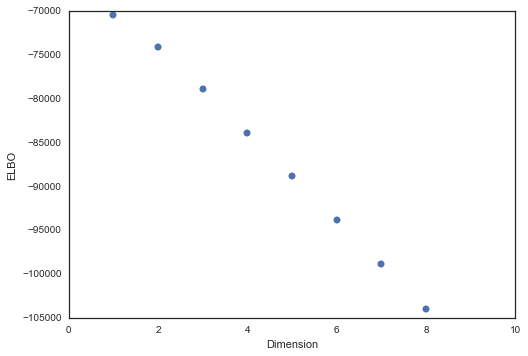

In [201]:
plt.plot(np.arange(maxl) + 1, elbo, linestyle='', marker='o');
plt.xlim([0, maxl + 2]);
plt.xlabel('Dimension');
plt.ylabel('ELBO');

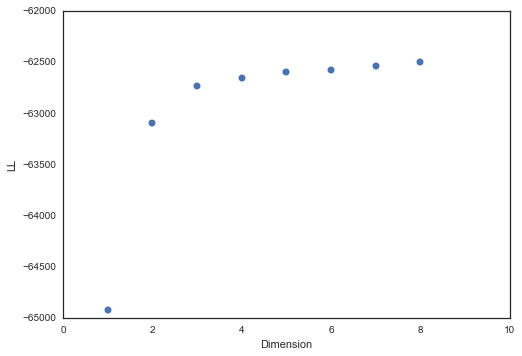

In [202]:
plt.plot(np.arange(maxl) + 1, ll, linestyle='', marker='o');
plt.xlim([0, maxl + 2]);
plt.xlabel('Dimension');
plt.ylabel('LL');

In [208]:
sample = loadmat('data/sample_lorenz2')

maxl = 6
pLL = np.zeros(maxl)
for l in range(maxl):
    sigma = np.full(l + 1, fill_value=1)
    omega = np.full(l + 1, fill_value=5e-4)

    yhat = np.empty_like(sample['y'])
    for i in range(sample['y'].shape[0]):
        model = inference.gpvb(sample['y'], None, sigma, omega, rank=100, lag=3, testidx=[i], tol=1e-5)
        yhat[i, :, :] = model['test']['yhat']
    vLGPpred = {'y':sample['y'], 'yhat': yhat}
    pLL[l] = stats.poisson.logpmf(vLGPpred['y'], vLGPpred['yhat']).mean()


Inference starting
Iteration[1], posterior elapsed: 0.21, parameter elapsed: 0.57, total elapsed: 0.88, ELBO: -194029.1684
Iteration[2], posterior elapsed: 0.21, parameter elapsed: 0.58, total elapsed: 0.88, ELBO: -100952.4628
Iteration[3], posterior elapsed: 0.21, parameter elapsed: 0.57, total elapsed: 0.88, ELBO: -73324.6872
Iteration[4], posterior elapsed: 0.21, parameter elapsed: 0.57, total elapsed: 0.88, ELBO: -67075.8659
Iteration[5], posterior elapsed: 0.21, parameter elapsed: 0.57, total elapsed: 0.87, ELBO: -65683.0332
Iteration[6], posterior elapsed: 0.21, parameter elapsed: 0.57, total elapsed: 0.87, ELBO: -64713.4419
Iteration[7], posterior elapsed: 0.21, parameter elapsed: 0.58, total elapsed: 0.88, ELBO: -64174.5639
Iteration[8], posterior elapsed: 0.21, parameter elapsed: 0.57, total elapsed: 0.87, ELBO: -64018.9675
Iteration[9], posterior elapsed: 0.21, parameter elapsed: 0.57, total elapsed: 0.88, ELBO: -63969.2013
Iteration[10], posterior elapsed: 0.21, parameter e

/Users/yuan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(1, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/yuan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(2, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)



Inference ending

5 iterations, ELBO: -7287.6338, elapsed: 0.17, converged: True


Inference starting
Iteration[1], posterior elapsed: 0.41, parameter elapsed: 0.59, total elapsed: 1.16, ELBO: -198611.3832
Iteration[2], posterior elapsed: 0.40, parameter elapsed: 0.58, total elapsed: 1.15, ELBO: -105438.7144
Iteration[3], posterior elapsed: 0.41, parameter elapsed: 0.59, total elapsed: 1.16, ELBO: -77758.7692
Iteration[4], posterior elapsed: 0.40, parameter elapsed: 0.59, total elapsed: 1.16, ELBO: -71412.7253
Iteration[5], posterior elapsed: 0.41, parameter elapsed: 0.59, total elapsed: 1.16, ELBO: -69882.8487
Iteration[6], posterior elapsed: 0.40, parameter elapsed: 0.58, total elapsed: 1.15, ELBO: -68660.5268
Iteration[7], posterior elapsed: 0.40, parameter elapsed: 0.59, total elapsed: 1.16, ELBO: -67706.3141
Iteration[8], posterior elapsed: 0.40, parameter elapsed: 0.59, total elapsed: 1.16, ELBO: -67280.1882
Iteration[9], posterior elapsed: 0.40, parameter elapsed: 0.59, total e

/Users/yuan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(3, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/yuan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(4, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)



Iteration[4], posterior elapsed: 0.07, parameter elapsed: 0.00, total elapsed: 0.09, ELBO: -8214.4385
Inference ending

4 iterations, ELBO: -8214.4385, elapsed: 0.38, converged: True


Inference starting
Iteration[1], posterior elapsed: 0.80, parameter elapsed: 0.61, total elapsed: 1.73, ELBO: -207716.9737
Iteration[2], posterior elapsed: 0.80, parameter elapsed: 0.62, total elapsed: 1.74, ELBO: -114456.6806
Iteration[3], posterior elapsed: 0.80, parameter elapsed: 0.59, total elapsed: 1.71, ELBO: -86715.0278
Iteration[4], posterior elapsed: 0.80, parameter elapsed: 0.59, total elapsed: 1.70, ELBO: -80144.0273
Iteration[5], posterior elapsed: 0.80, parameter elapsed: 0.59, total elapsed: 1.70, ELBO: -78563.9502
Iteration[6], posterior elapsed: 0.80, parameter elapsed: 0.60, total elapsed: 1.72, ELBO: -77626.6385
Iteration[7], posterior elapsed: 0.80, parameter elapsed: 0.59, total elapsed: 1.71, ELBO: -76946.3354
Iteration[8], posterior elapsed: 0.79, parameter elapsed: 0.59, total el

/Users/yuan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(5, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/yuan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(6, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)



Inference ending

5 iterations, ELBO: -9214.7515, elapsed: 0.78, converged: True


Inference starting
Iteration[1], posterior elapsed: 1.18, parameter elapsed: 0.62, total elapsed: 2.27, ELBO: -216860.8403
Iteration[2], posterior elapsed: 1.19, parameter elapsed: 0.60, total elapsed: 2.25, ELBO: -123464.1701
Iteration[3], posterior elapsed: 1.17, parameter elapsed: 0.61, total elapsed: 2.24, ELBO: -95558.4040
Iteration[4], posterior elapsed: 1.17, parameter elapsed: 0.60, total elapsed: 2.24, ELBO: -88927.1205
Iteration[5], posterior elapsed: 1.18, parameter elapsed: 0.61, total elapsed: 2.24, ELBO: -87353.2381
Iteration[6], posterior elapsed: 1.18, parameter elapsed: 0.60, total elapsed: 2.23, ELBO: -86540.6200
Iteration[7], posterior elapsed: 1.18, parameter elapsed: 0.60, total elapsed: 2.24, ELBO: -86021.8239
Iteration[8], posterior elapsed: 1.17, parameter elapsed: 0.60, total elapsed: 2.23, ELBO: -85738.4060
Iteration[9], posterior elapsed: 1.17, parameter elapsed: 0.60, total e

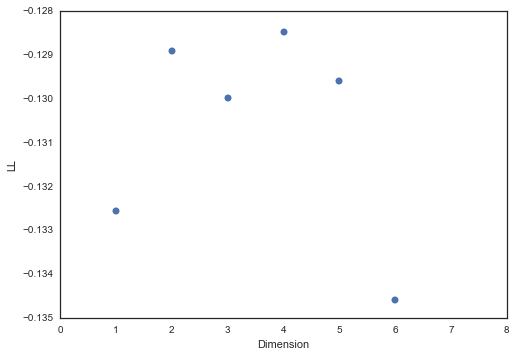

In [209]:
plt.plot(np.arange(maxl) + 1, pLL, linestyle='', marker='o');
plt.xlim([0, maxl + 2]);
plt.xlabel('Dimension');
plt.ylabel('LL');

In [254]:
np.array([True]).dtype

dtype('bool')

In [260]:
np.log1p(1000)

6.9088

In [261]:
np.log(1000)

6.9078

In [270]:
os.path.expanduser("~")

'/Users/yuan'